In [1]:
!pip install transformers
!pip install bertopic
!pip install nltk
!pip install requests
!pip install pandas
!pip install torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [84]:
import requests
import xml.etree.ElementTree as ET
import pandas as pd
import time

queries = [
    "graph neural networks","explainable AI","federated learning",
    "edge computing","synthetic biology","digital twins",
    "biomedical informatics","CRISPR gene editing","blockchain in healthcare",
    "emotion recognition","autonomous vehicles","green computing",
    "AI ethics in medicine","AI in education","quantum machine learning",
    "computational sustainability", "climate change","quantum computing"
]


all_data = []

# Function to fetch data from ArXiv API
def fetch_arxiv_data(query, start=0, max_results=100):
    url = f"http://export.arxiv.org/api/query?search_query=all:{query}&start={start}&max_results={max_results}"
    response = requests.get(url)
    if response.status_code == 200:
        root = ET.fromstring(response.text)
        papers = []
        for entry in root.findall("{http://www.w3.org/2005/Atom}entry"):
            papers.append({
                'title': entry.find("{http://www.w3.org/2005/Atom}title").text,
                'abstract': entry.find("{http://www.w3.org/2005/Atom}summary").text,
                'published': entry.find("{http://www.w3.org/2005/Atom}published").text,
                'source': 'arXiv'
            })
        return papers
    return []




In [85]:
# Function to fetch data from PubMed API
def fetch_pubmed_data(query, retmax=10):
    search_url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term={query}&retmax={retmax}&retmode=json"
    search_response = requests.get(search_url).json()
    pmids = search_response.get('esearchresult', {}).get('idlist', [])
    papers = []
    if pmids:
        ids = ",".join(pmids)
        fetch_url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&id={ids}&retmode=xml"
        fetch_response = requests.get(fetch_url)
        root = ET.fromstring(fetch_response.text)
        for article in root.findall(".//PubmedArticle"):
            title = article.find(".//ArticleTitle").text
            abstract = article.find(".//AbstractText")
            abstract = abstract.text if abstract is not None else "No abstract"
            date = article.find(".//PubDate/Year").text if article.find(".//PubDate/Year") else "No date"
            papers.append({
                'title': title,
                'abstract': abstract,
                'published': date,
                'source': 'PubMed'
            })
    return papers

In [86]:
# Function to fetch data from CrossRef API
def fetch_crossref_data(query, rows=10):
    url = f"https://api.crossref.org/works?query={query}&rows={rows}"
    response = requests.get(url)
    papers = []
    if response.status_code == 200:
        results = response.json().get("message", {}).get("items", [])
        for item in results:
            title = item.get("title", ["No title"])[0]
            abstract = item.get("abstract", "No abstract")
            date_parts = item.get("published-print", {}).get("date-parts", [[None]])
            year = date_parts[0][0] if date_parts[0][0] is not None else "No date"
            papers.append({
                'title': title,
                'abstract': abstract,
                'published': year,
                'source': 'CrossRef'
            })
    return papers

In [87]:
# Fetch data for each query from ArXiv, PubMed, and CrossRef
for query in queries:
    print(f"Fetching data for query: {query}")


    for start in range(0, 500, 100):  # Fetch up to 500 results in batches of 100
        all_data.extend(fetch_arxiv_data(query, start=start, max_results=100))
        time.sleep(1)  # Delay to avoid rate limits

    all_data.extend(fetch_pubmed_data(query))
    all_data.extend(fetch_crossref_data(query))


df = pd.DataFrame(all_data)
df['published_date'] = pd.to_datetime(df['published'], errors='coerce').dt.to_period("Y")
print(f"Total entries collected: {len(df)}")
df.head()

Fetching data for query: graph neural networks
Fetching data for query: explainable AI
Fetching data for query: federated learning
Fetching data for query: edge computing
Fetching data for query: synthetic biology
Fetching data for query: digital twins
Fetching data for query: biomedical informatics
Fetching data for query: CRISPR gene editing
Fetching data for query: blockchain in healthcare
Fetching data for query: emotion recognition
Fetching data for query: autonomous vehicles
Fetching data for query: green computing
Fetching data for query: AI ethics in medicine
Fetching data for query: AI in education
Fetching data for query: quantum machine learning
Fetching data for query: computational sustainability
Fetching data for query: climate change
Fetching data for query: quantum computing
Total entries collected: 8851


,title,abstract,published,source,published_date
0,A Survey on Graph Classification and Link Pred...,Traditional convolutional neural networks ar...,2023-07-03T09:08:01Z,arXiv,2023
1,Graph Structure of Neural Networks,Neural networks are often represented as gra...,2020-07-13T17:59:31Z,arXiv,2020
2,Sampling and Recovery of Graph Signals based o...,We propose interpretable graph neural networ...,2020-11-03T01:45:41Z,arXiv,2020
3,Superhypergraph Neural Networks and Plithogeni...,Hypergraphs extend traditional graphs by all...,2024-12-02T06:33:02Z,arXiv,2024
4,Graph Neural Networks for Small Graph and Gian...,Graph neural networks denote a group of neur...,2019-08-01T02:35:12Z,arXiv,2019


In [88]:
import nltk
nltk.data.path.clear()


In [89]:
!pip install spacy
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 55.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [90]:
import re
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic

nlp = spacy.load("en_core_web_sm")


def preprocess_text(text):
    if text is None:
        return []
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    return tokens

df['processed_abstract'] = df['abstract'].apply(preprocess_text)

df.head()

,title,abstract,published,source,published_date,processed_abstract
0,A Survey on Graph Classification and Link Pred...,Traditional convolutional neural networks ar...,2023-07-03T09:08:01Z,arXiv,2023,"[traditional, convolutional, neural, network, ..."
1,Graph Structure of Neural Networks,Neural networks are often represented as gra...,2020-07-13T17:59:31Z,arXiv,2020,"[neural, network, represent, graph, connection..."
2,Sampling and Recovery of Graph Signals based o...,We propose interpretable graph neural networ...,2020-11-03T01:45:41Z,arXiv,2020,"[propose, interpretable, graph, neural, networ..."
3,Superhypergraph Neural Networks and Plithogeni...,Hypergraphs extend traditional graphs by all...,2024-12-02T06:33:02Z,arXiv,2024,"[hypergraph, extend, traditional, graph, allow..."
4,Graph Neural Networks for Small Graph and Gian...,Graph neural networks denote a group of neur...,2019-08-01T02:35:12Z,arXiv,2019,"[graph, neural, network, denote, group, neural..."


In [91]:
# Specify the directory for NLTK data
import nltk
nltk.data.path.append('/usr/local/share/nltk_data/')

# Download necessary NLTK resources again
nltk.download('punkt', download_dir='/usr/local/share/nltk_data/')
nltk.download('stopwords', download_dir='/usr/local/share/nltk_data/')


[nltk_data] Downloading package punkt to
[nltk_data]     /usr/local/share/nltk_data/...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /usr/local/share/nltk_data/...
[nltk_data]   Package stopwords is already up-to-date!


True

In [92]:
import pandas as pd

df['published_date'] = pd.to_datetime(df['published'], errors='coerce').dt.to_period("Y")

# Save the DataFrame to an Excel file
output_file = "data.xlsx"
df.to_excel(output_file, index=False)

print(f"Data successfully saved to {output_file}")


Data successfully saved to data.xlsx


In [93]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# TF-IDF Analysis
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_abstract'].apply(lambda x: ' '.join(x)))
terms = tfidf_vectorizer.get_feature_names_out()


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])
        return out


term_freq_time_series = df['processed_abstract'].apply(lambda x: ' '.join(x)).value_counts().sort_index()
data = []
labels = []
sequence_length = 10
for i in range(len(term_freq_time_series) - sequence_length):
    data.append(term_freq_time_series.values[i:i + sequence_length])
    labels.append(term_freq_time_series.values[i + sequence_length])

dataset = TensorDataset(torch.tensor(data, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32))
data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

input_size = 1
hidden_size = 50
output_size = 1
lstm_model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

for epoch in range(50):
    for seq, target in data_loader:
        optimizer.zero_grad()
        output = lstm_model(seq.unsqueeze(-1))
        loss = criterion(output.squeeze(), target)
        loss.backward()
        optimizer.step()


In [94]:
df['published_date'] = pd.to_datetime(df['published'], errors='coerce')
df['year'] = df['published_date'].dt.year
df['year'] = df['year'].astype('Int64')

In [95]:
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

terms_of_interest = [
    "federated learning","edge computing","synthetic biology",
    "digital twins", "emotion recognition","autonomous vehicles",
    "green computing", "quantum machine learning","quantum computing",
    "climate change"]

term_embeddings_over_time = {}

# Process each term over all available years
for term in terms_of_interest:
    term_embeddings_over_time[term] = {}
    for year in sorted(df['year'].dropna().unique()):  # Ensure 'year' column exists and is valid
        # Filter abstracts published in the current year
        texts = df[df['year'] == year]['processed_abstract'].apply(lambda x: ' '.join(x)).tolist()

        # Initialize a list to store embeddings for each paper containing the term in the specified year
        yearly_embeddings = []

        for text in texts:
            # Only include papers containing the term
            if term in text:
                inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
                outputs = model(**inputs)
                embedding = outputs.last_hidden_state.mean(dim=1).detach().numpy()
                yearly_embeddings.append(embedding)

        # Calculate the average embedding for the term in this year if any papers matched
        if yearly_embeddings:
            term_embeddings_over_time[term][year] = np.mean(yearly_embeddings, axis=0)
        else:
            term_embeddings_over_time[term][year] = None  # No data for this term in this year

volatility_scores = {}
for term, yearly_embeddings in term_embeddings_over_time.items():
    years = sorted(yearly_embeddings.keys())
    scores = []
    for i in range(1, len(years)):
        if yearly_embeddings[years[i - 1]] is not None and yearly_embeddings[years[i]] is not None:
            # Compute cosine similarity between consecutive years
            sim = cosine_similarity(yearly_embeddings[years[i - 1]], yearly_embeddings[years[i]])
            scores.append(1 - sim[0][0])  # Volatility is 1 - similarity
    volatility_scores[term] = np.mean(scores) if scores else 0

print("Context Volatility Scores:\n", volatility_scores)


Context Volatility Scores:
 {'federated learning': np.float32(0.012284858), 'edge computing': np.float32(0.007528636), 'synthetic biology': np.float32(0.03147765), 'digital twins': 0, 'emotion recognition': np.float32(0.01644068), 'autonomous vehicles': 0, 'green computing': np.float32(0.15005168), 'quantum machine learning': np.float32(0.027178884), 'quantum computing': np.float32(0.040091205), 'climate change': np.float32(0.040903226)}


In [96]:
# Calculate term frequencies
term_frequencies = {term: {} for term in terms_of_interest}

for term in terms_of_interest:
    for year in sorted(df['year'].dropna().unique()):
        # Count occurrences of the exact term in abstracts for the given year
        term_frequencies[term][year] = df[df['year'] == year]['processed_abstract'].apply(
            lambda x: f" {term} " in f" {' '.join(x)} ".lower()  # Ensure exact matching
        ).sum()

term_frequencies_df = pd.DataFrame(term_frequencies).fillna(0).astype(int)
term_frequencies_df.index.name = 'Year'


In [97]:
ranks = term_frequencies_df["emotion recognition"].rank(method="min", ascending=False)

rank_diff = ranks.diff().abs()

# Compute rank-based volatility
rank_based_volatility = rank_diff.mean()

print(f"Rank-Based Volatility for 'emotion recognition': {rank_based_volatility}\n")
print(ranks)

Rank-Based Volatility for 'emotion recognition': 1.1515151515151516

Year
1992    16.0
1993    16.0
1994    16.0
1995    16.0
1996    16.0
1997    16.0
1998    16.0
1999    16.0
2000    16.0
2001    16.0
2002    16.0
2003    16.0
2004    16.0
2005    16.0
2006    16.0
2007    16.0
2008    16.0
2009    14.0
2010    14.0
2011    16.0
2012    13.0
2013    16.0
2014    11.0
2015    12.0
2016     9.0
2017    10.0
2018     7.0
2019     8.0
2020     4.0
2021     5.0
2022     3.0
2023     2.0
2024     1.0
2025     6.0
Name: emotion recognition, dtype: float64


In [28]:
ranks = term_frequencies_df["quantum machine learning"].rank(method="min", ascending=False)

rank_diff = ranks.diff().abs()

# Compute rank-based volatility
rank_based_volatility = rank_diff.mean()

print(f"Rank-Based Volatility for 'quantum machine learning': {rank_based_volatility}\n")
print(ranks)


Rank-Based Volatility for 'quantum machine learning': 0.6666666666666666

Year
1992    14.0
1993    14.0
1994    14.0
1995    14.0
1996    14.0
1997    14.0
1998    14.0
1999    14.0
2000    14.0
2001    14.0
2002    14.0
2003    14.0
2004    14.0
2005    14.0
2006    14.0
2007    14.0
2008    14.0
2009    14.0
2010    14.0
2011    14.0
2012    14.0
2013    12.0
2014    12.0
2015    11.0
2016     9.0
2017     9.0
2018     7.0
2019     8.0
2020     5.0
2021     3.0
2022     4.0
2023     2.0
2024     1.0
2025     6.0
Name: quantum machine learning, dtype: float64


In [38]:
ranks = term_frequencies_df["federated learning"].rank(method="min", ascending=False)

rank_diff = ranks.diff().abs()

# Compute rank-based volatility
rank_based_volatility = rank_diff.mean()

print(f"Rank-Based Volatility for 'federated learning': {rank_based_volatility}\n")
print(ranks)


Rank-Based Volatility for 'federated learning': 0.48484848484848486

Year
1992    9.0
1993    9.0
1994    9.0
1995    9.0
1996    9.0
1997    9.0
1998    9.0
1999    9.0
2000    9.0
2001    9.0
2002    9.0
2003    9.0
2004    9.0
2005    9.0
2006    9.0
2007    9.0
2008    9.0
2009    9.0
2010    9.0
2011    9.0
2012    9.0
2013    9.0
2014    9.0
2015    9.0
2016    9.0
2017    9.0
2018    8.0
2019    6.0
2020    4.0
2021    5.0
2022    2.0
2023    1.0
2024    3.0
2025    7.0
Name: federated learning, dtype: float64


In [30]:
ranks = term_frequencies_df["synthetic biology"].rank(method="min", ascending=False)

rank_diff = ranks.diff().abs()

# Compute rank-based volatility
rank_based_volatility = rank_diff.mean()

print(f"Rank-Based Volatility for 'synthetic biology': {rank_based_volatility}\n")
print(ranks)


Rank-Based Volatility for 'synthetic biology': 1.7575757575757576

Year
1992    20.0
1993    20.0
1994    20.0
1995    20.0
1996    20.0
1997    20.0
1998    20.0
1999    20.0
2000    20.0
2001    20.0
2002    20.0
2003    20.0
2004    20.0
2005    20.0
2006    20.0
2007    19.0
2008    16.0
2009    18.0
2010    16.0
2011    15.0
2012    12.0
2013    10.0
2014     8.0
2015    11.0
2016    12.0
2017     5.0
2018     5.0
2019     2.0
2020     4.0
2021     1.0
2022     5.0
2023     8.0
2024     3.0
2025    14.0
Name: synthetic biology, dtype: float64


In [50]:
ranks = term_frequencies_df["digital twins"].rank(method="min", ascending=False)

rank_diff = ranks.diff().abs()

# Compute rank-based volatility
rank_based_volatility = rank_diff.mean()

print(f"Rank-Based Volatility for 'digital twins': {rank_based_volatility}\n")
print(ranks)

Rank-Based Volatility for 'digital twins': 0.18181818181818182

Year
1992    3.0
1993    3.0
1994    3.0
1995    3.0
1996    3.0
1997    3.0
1998    3.0
1999    3.0
2000    3.0
2001    3.0
2002    3.0
2003    3.0
2004    3.0
2005    3.0
2006    3.0
2007    3.0
2008    3.0
2009    3.0
2010    3.0
2011    3.0
2012    3.0
2013    3.0
2014    3.0
2015    3.0
2016    3.0
2017    3.0
2018    3.0
2019    3.0
2020    3.0
2021    3.0
2022    2.0
2023    3.0
2024    1.0
2025    3.0
Name: digital twins, dtype: float64


In [54]:
ranks = term_frequencies_df["edge computing"].rank(method="min", ascending=False)

rank_diff = ranks.diff().abs()

# Compute rank-based volatility
rank_based_volatility = rank_diff.mean()

print(f"Rank-Based Volatility for 'edge computing': {rank_based_volatility}\n")
print(ranks)

Rank-Based Volatility for 'edge computing': 0.7575757575757576

Year
1992    11.0
1993    11.0
1994    11.0
1995    11.0
1996    11.0
1997    11.0
1998    11.0
1999    11.0
2000    11.0
2001    11.0
2002    11.0
2003    11.0
2004    11.0
2005    11.0
2006    11.0
2007    11.0
2008    11.0
2009    11.0
2010    11.0
2011    11.0
2012    11.0
2013    11.0
2014    11.0
2015    11.0
2016    10.0
2017     9.0
2018     7.0
2019     4.0
2020     3.0
2021     1.0
2022     6.0
2023     5.0
2024     2.0
2025     8.0
Name: edge computing, dtype: float64


In [60]:
ranks = term_frequencies_df["green computing"].rank(method="min", ascending=False)

rank_diff = ranks.diff().abs()

# Compute rank-based volatility
rank_based_volatility = rank_diff.mean()

print(f"Rank-Based Volatility for 'edge computing': {rank_based_volatility}\n")
print(ranks)

Rank-Based Volatility for 'edge computing': 1.3636363636363635

Year
1992    6.0
1993    6.0
1994    6.0
1995    6.0
1996    6.0
1997    6.0
1998    6.0
1999    6.0
2000    6.0
2001    6.0
2002    6.0
2003    6.0
2004    6.0
2005    6.0
2006    6.0
2007    6.0
2008    6.0
2009    6.0
2010    6.0
2011    6.0
2012    1.0
2013    6.0
2014    6.0
2015    6.0
2016    6.0
2017    6.0
2018    1.0
2019    6.0
2020    1.0
2021    6.0
2022    6.0
2023    1.0
2024    6.0
2025    1.0
Name: green computing, dtype: float64


In [98]:
ranks = term_frequencies_df["climate change"].rank(method="min", ascending=False)

rank_diff = ranks.diff().abs()

# Compute rank-based volatility
rank_based_volatility = rank_diff.mean()

print(f"Rank-Based Volatility for 'climate change': {rank_based_volatility}\n")
print(ranks)

Rank-Based Volatility for 'climate change': 2.1818181818181817

Year
1992    24.0
1993    24.0
1994    24.0
1995    24.0
1996    24.0
1997    24.0
1998    24.0
1999    24.0
2000    24.0
2001    24.0
2002    24.0
2003    22.0
2004    17.0
2005    19.0
2006    19.0
2007    22.0
2008    15.0
2009    12.0
2010    17.0
2011    15.0
2012    13.0
2013    19.0
2014    11.0
2015     8.0
2016    10.0
2017    13.0
2018     9.0
2019     7.0
2020     5.0
2021     3.0
2022     4.0
2023     2.0
2024     1.0
2025     6.0
Name: climate change, dtype: float64


In [99]:
ranks = term_frequencies_df["quantum computing"].rank(method="min", ascending=False)

rank_diff = ranks.diff().abs()

# Compute rank-based volatility
rank_based_volatility = rank_diff.mean()

print(f"Rank-Based Volatility for 'quantum computing': {rank_based_volatility}\n")
print(ranks)

Rank-Based Volatility for 'quantum computing': 5.090909090909091

Year
1992    26.0
1993    26.0
1994    26.0
1995    26.0
1996    19.0
1997    19.0
1998    26.0
1999    19.0
2000     9.0
2001    24.0
2002    24.0
2003    26.0
2004    19.0
2005    11.0
2006    26.0
2007    19.0
2008    14.0
2009    26.0
2010    14.0
2011    26.0
2012    14.0
2013    14.0
2014    11.0
2015    14.0
2016     9.0
2017    11.0
2018     7.0
2019     8.0
2020     5.0
2021     4.0
2022     3.0
2023     2.0
2024     1.0
2025     6.0
Name: quantum computing, dtype: float64


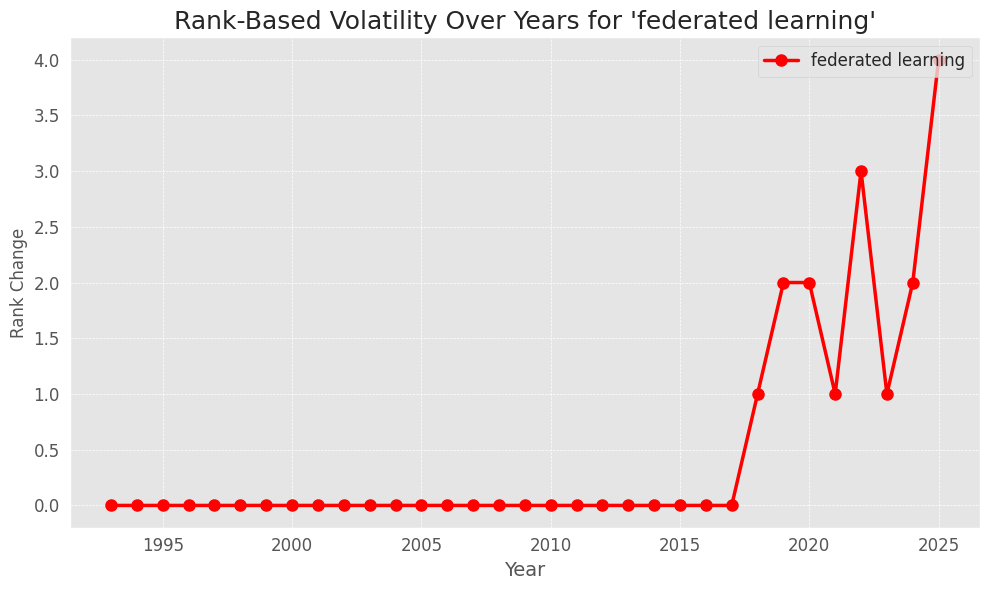

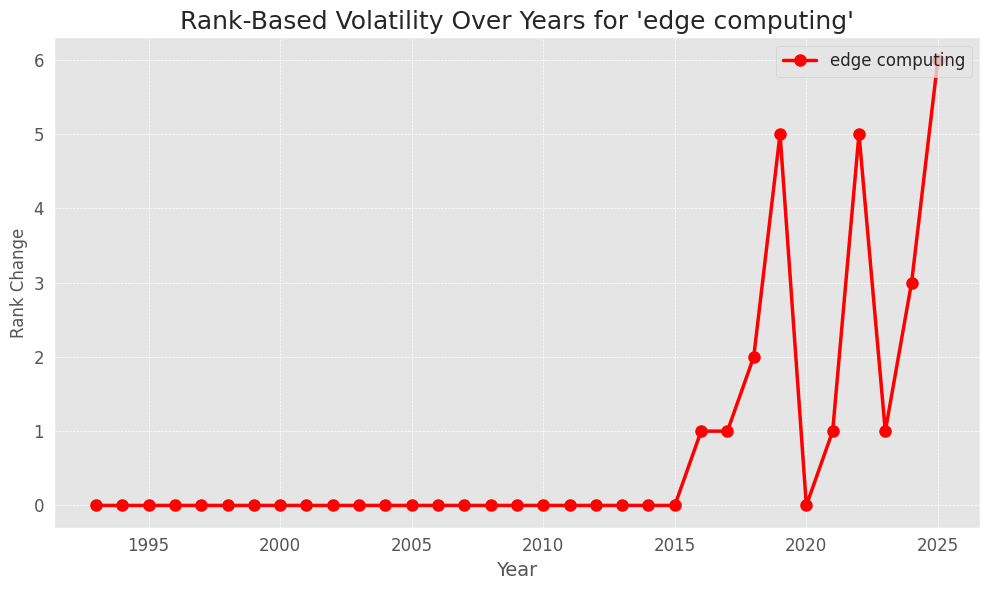

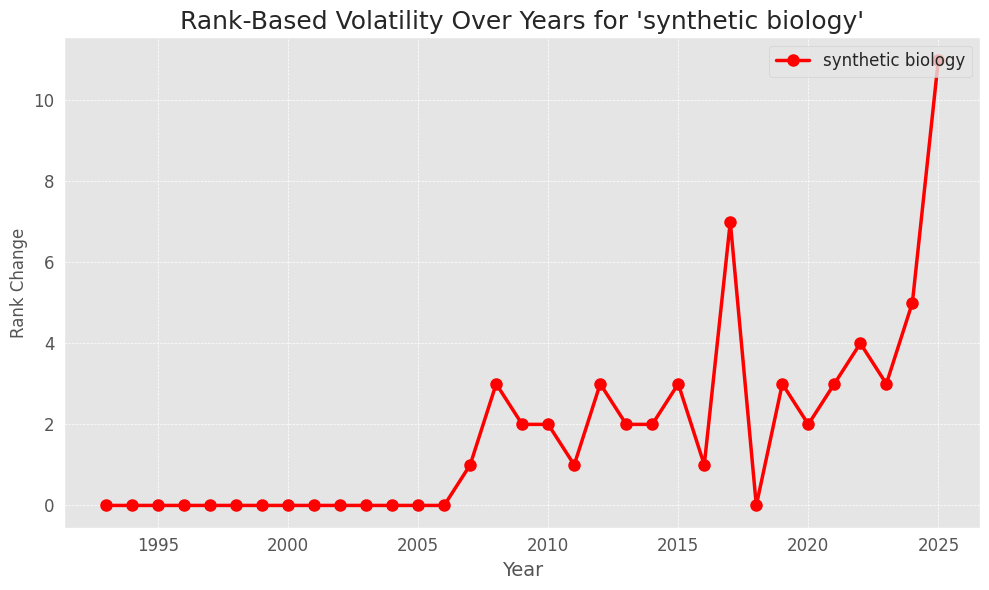

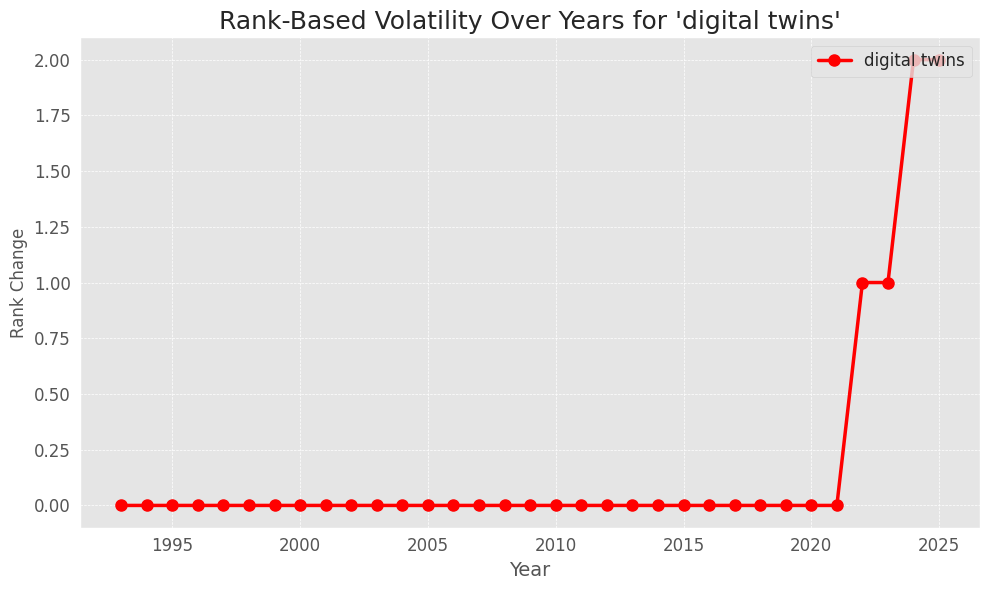

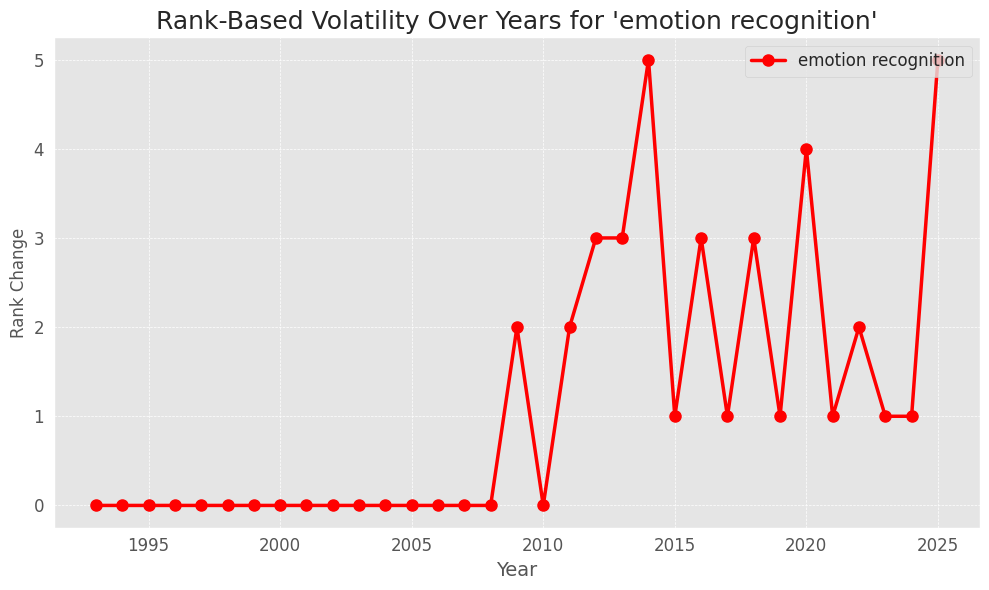

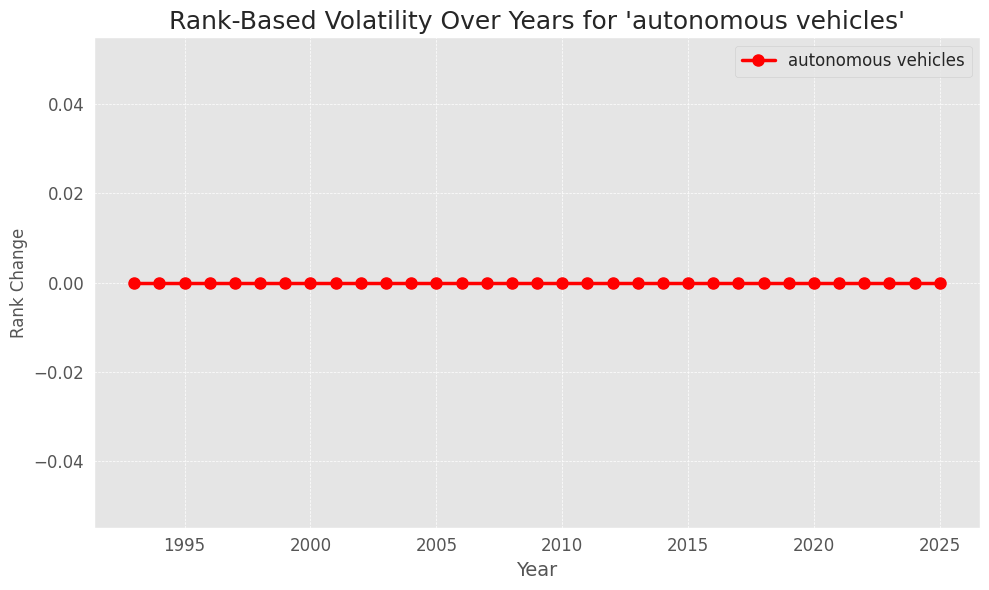

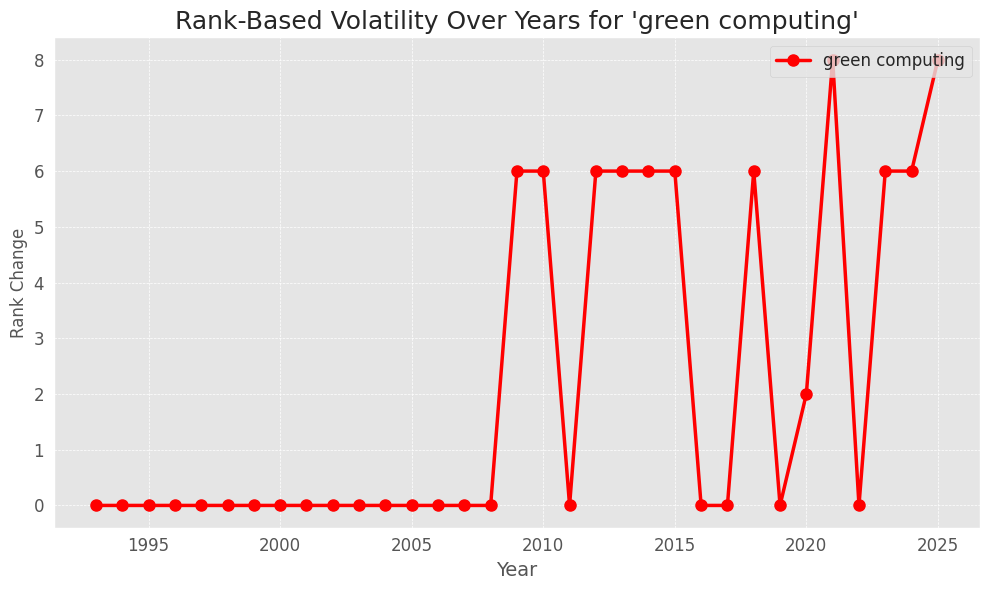

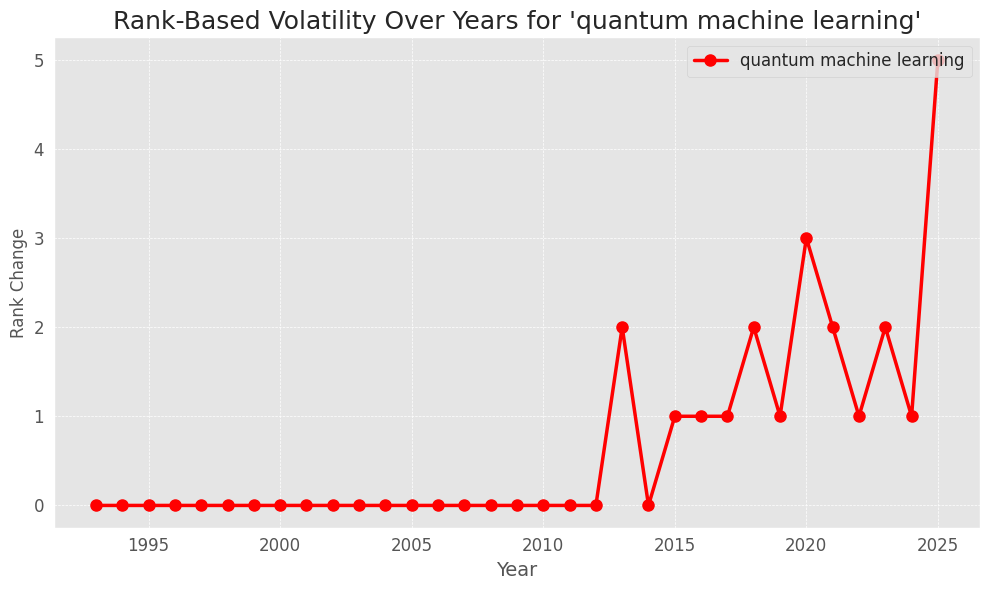

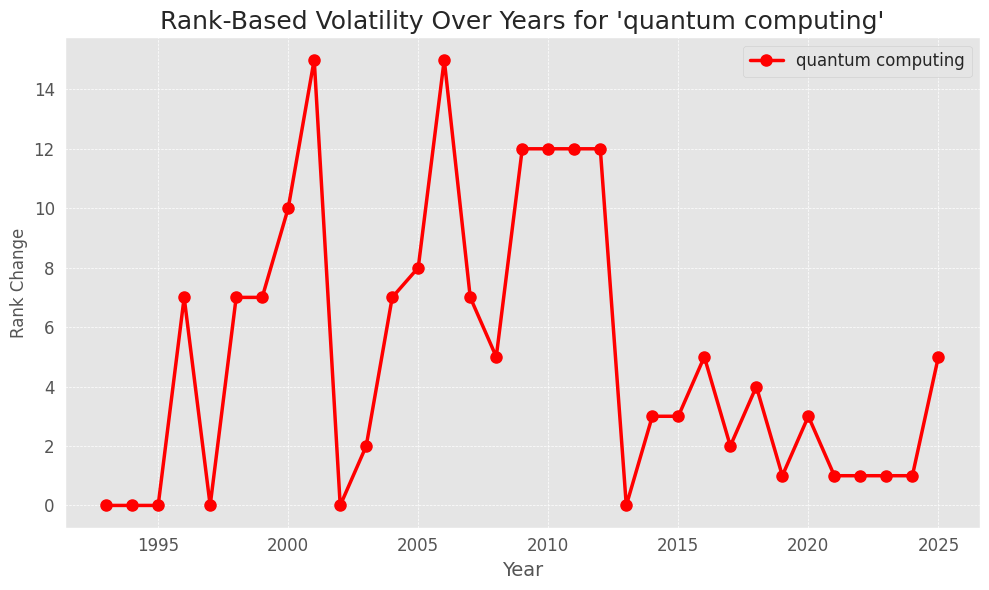

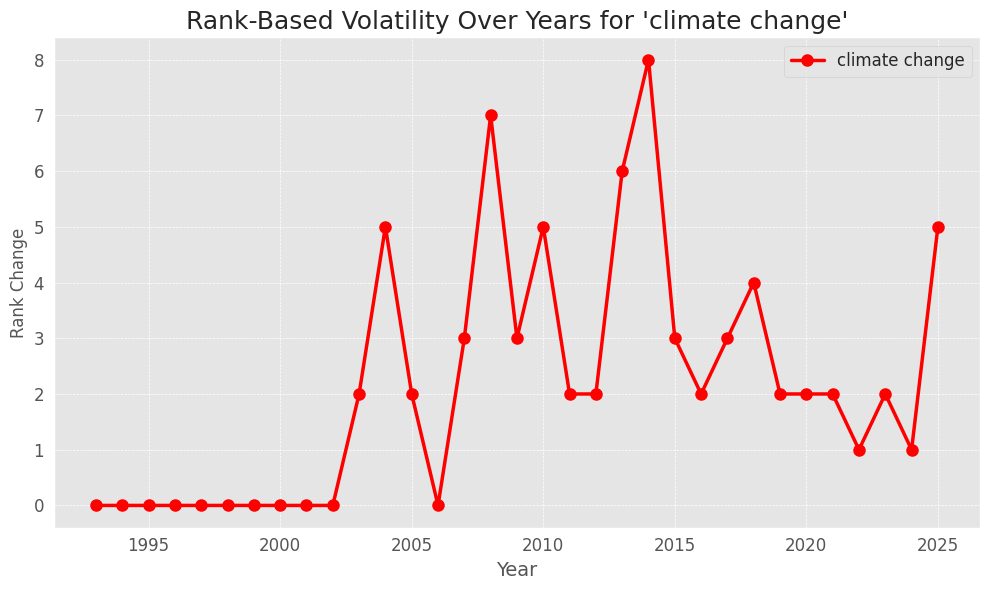

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

plt.style.use("ggplot")

for term in terms_of_interest:
    ranks = term_frequencies_df[term].rank(method="min", ascending=False)
    rank_diff = ranks.diff().abs()

    plt.figure(figsize=(10, 6))
    plt.plot(rank_diff.index, rank_diff.values,
             marker='o', markersize=8, linewidth=2.5,
             label=f"{term}", color='red')

    plt.title(f"Rank-Based Volatility Over Years for '{term}'", fontsize=18)
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Rank Change", fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.legend(fontsize=12, loc='upper right')
    plt.tight_layout()
    plt.show()



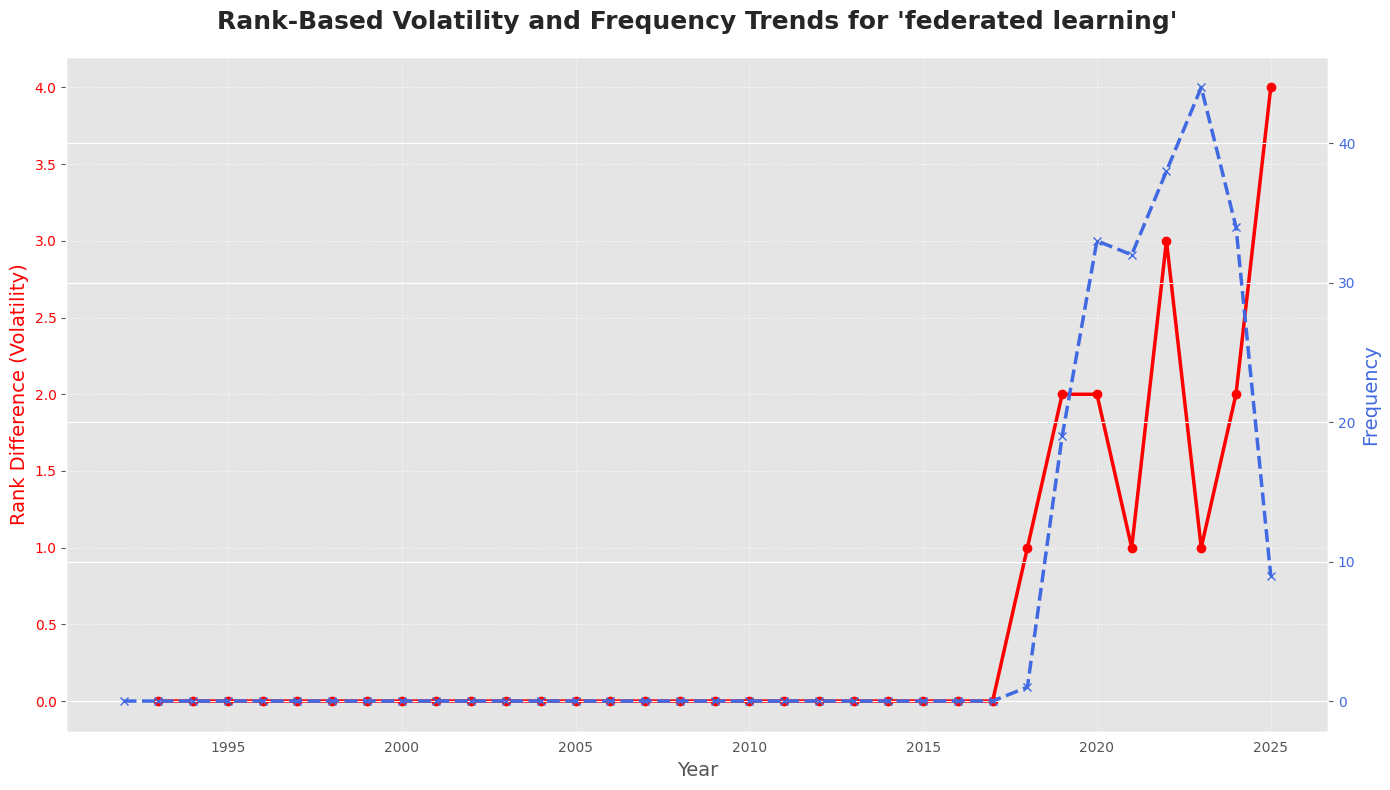

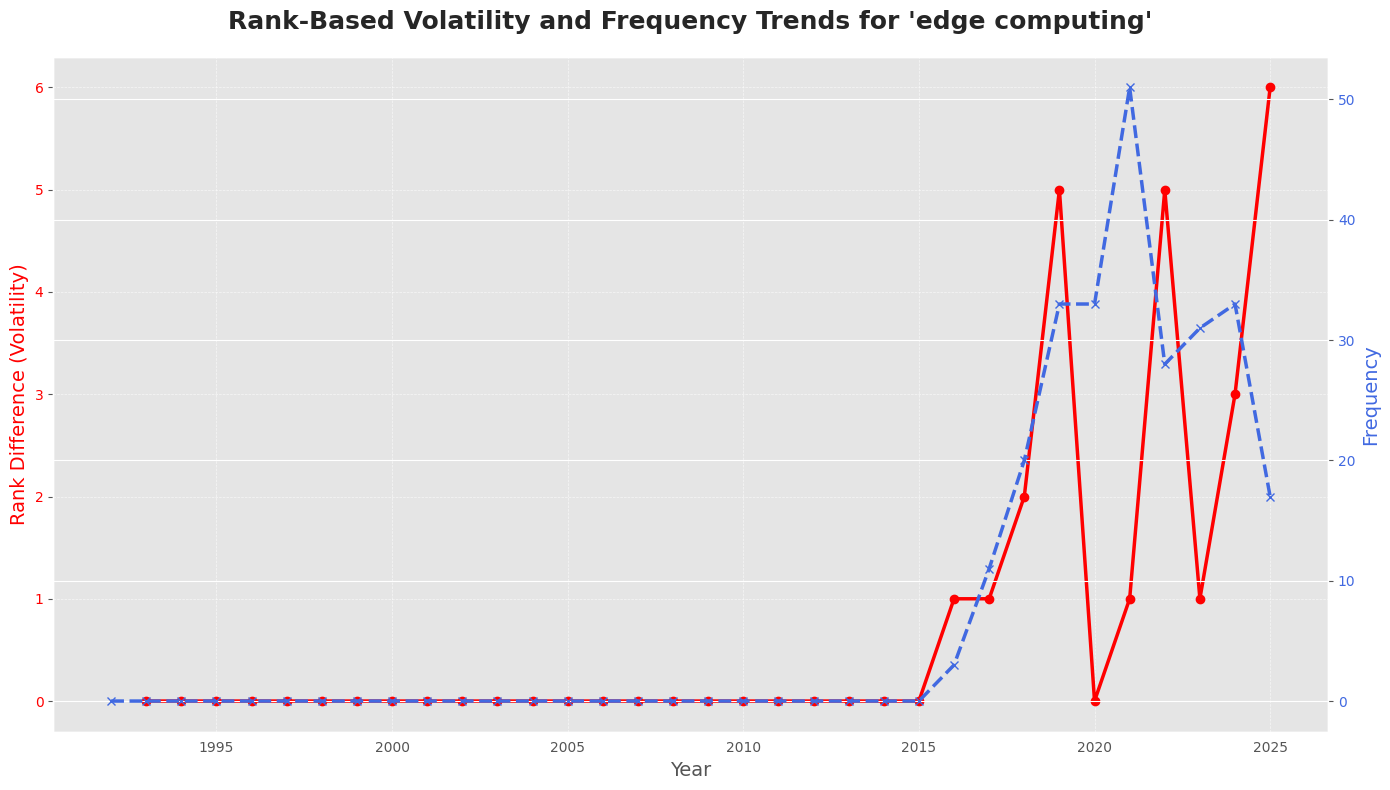

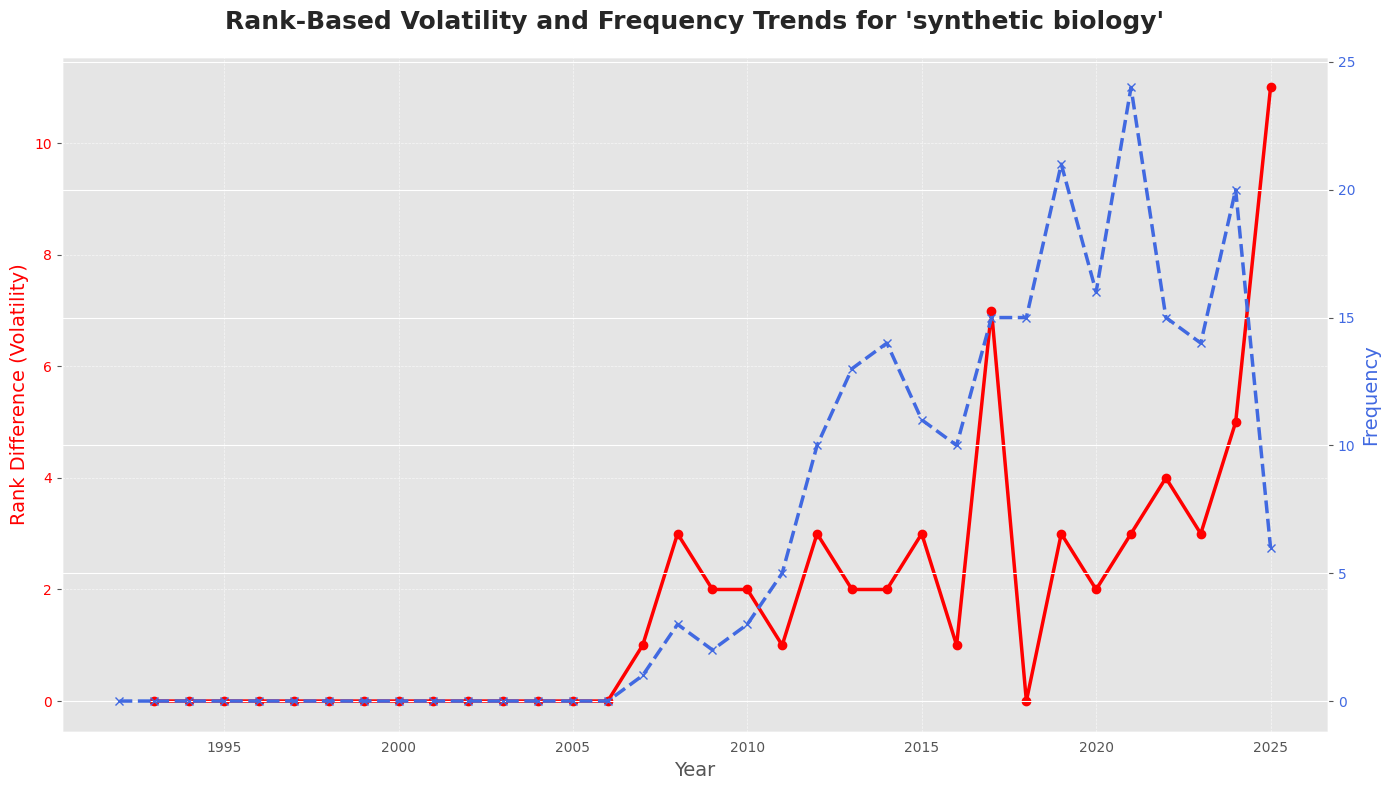

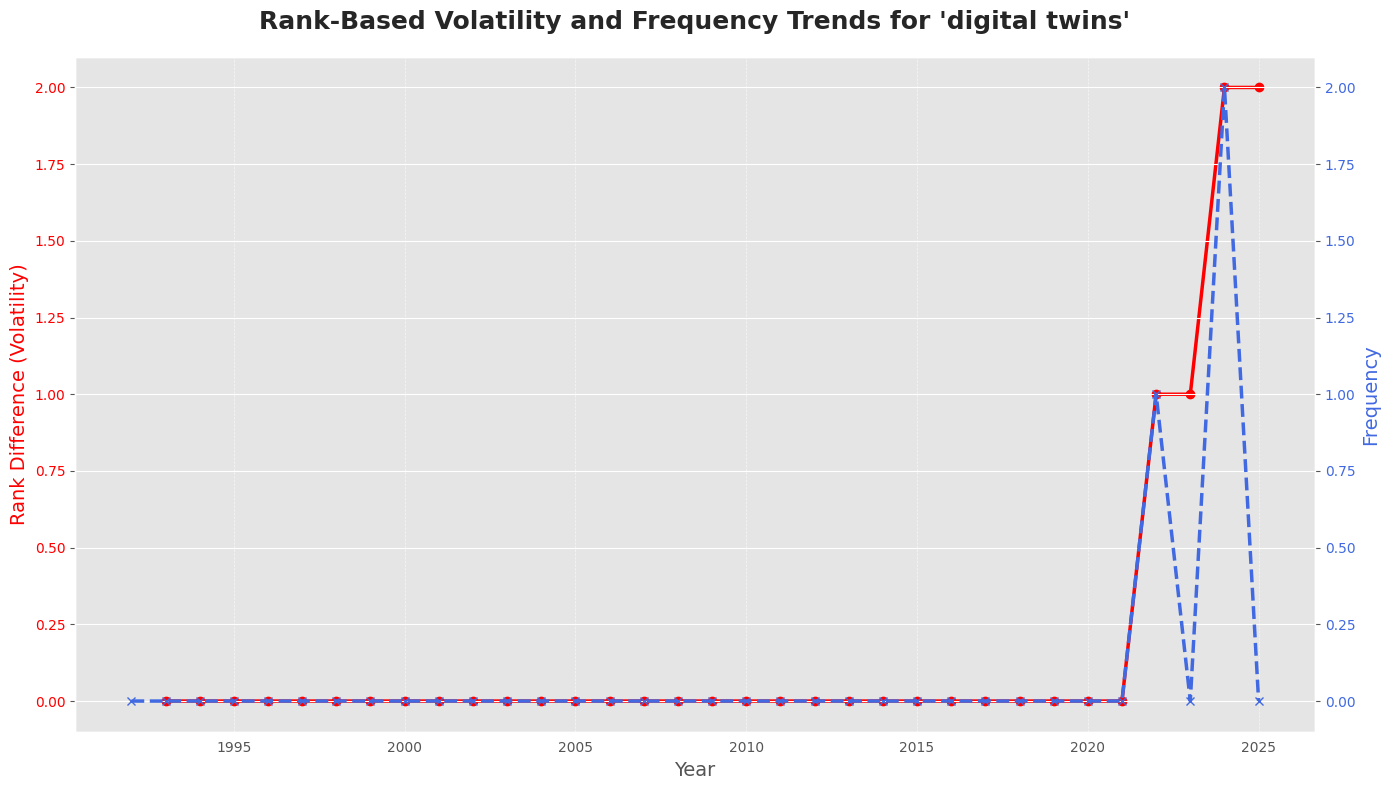

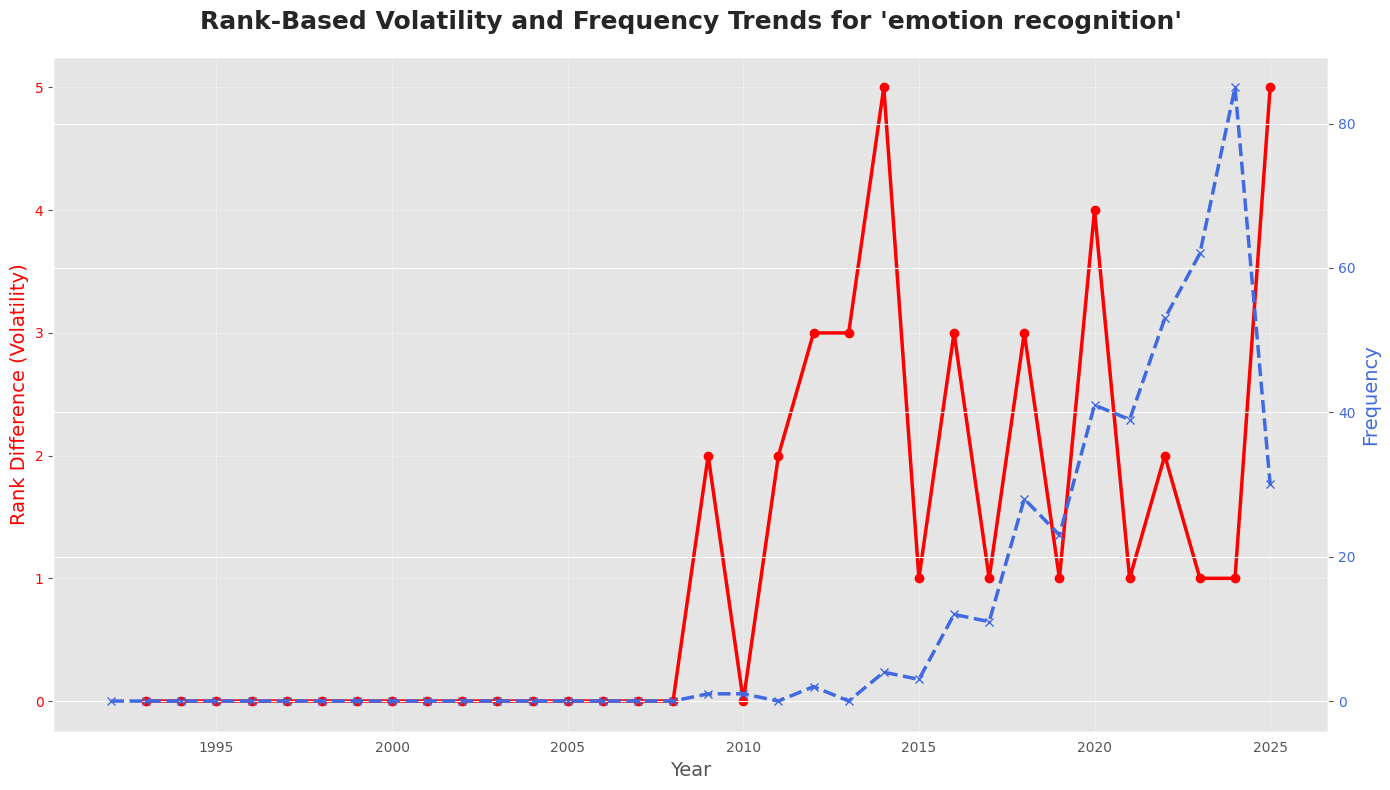

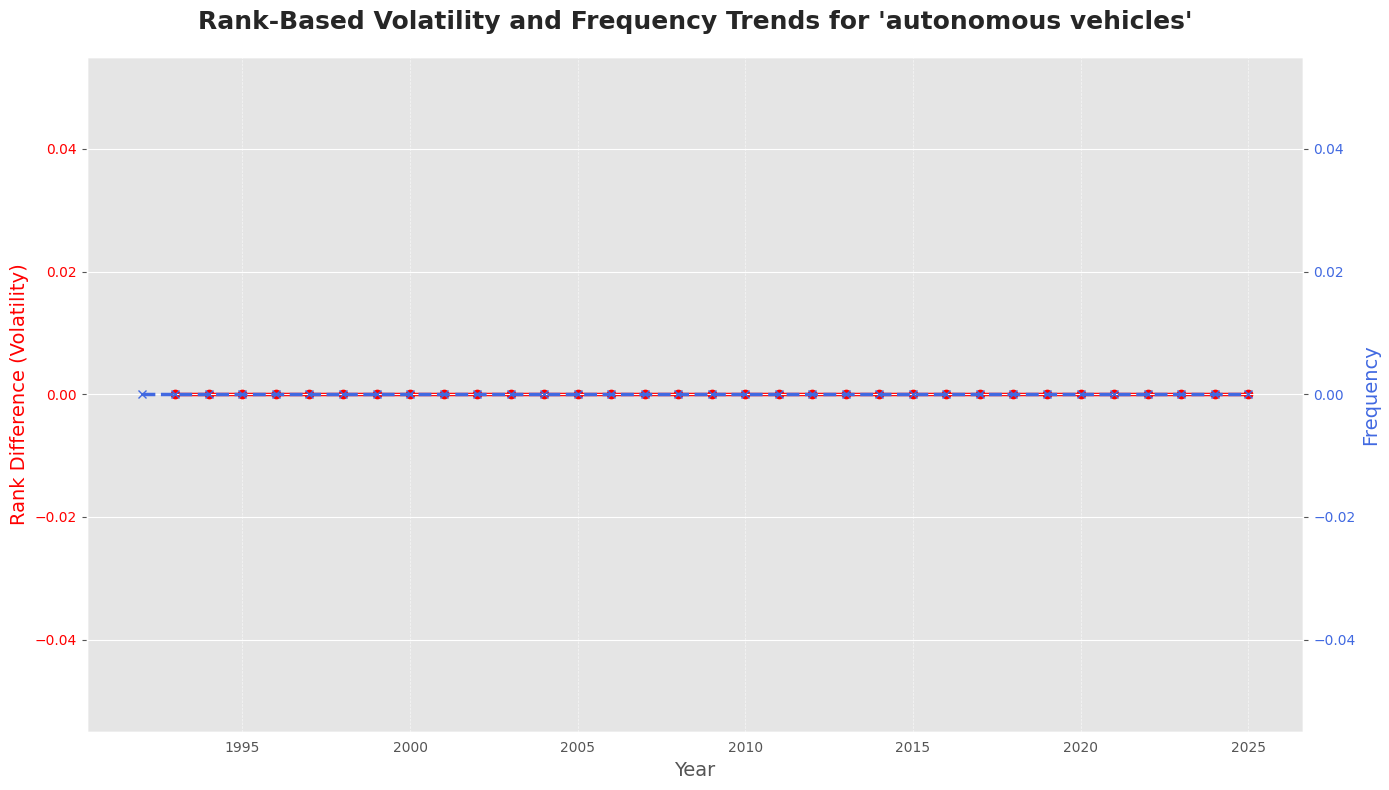

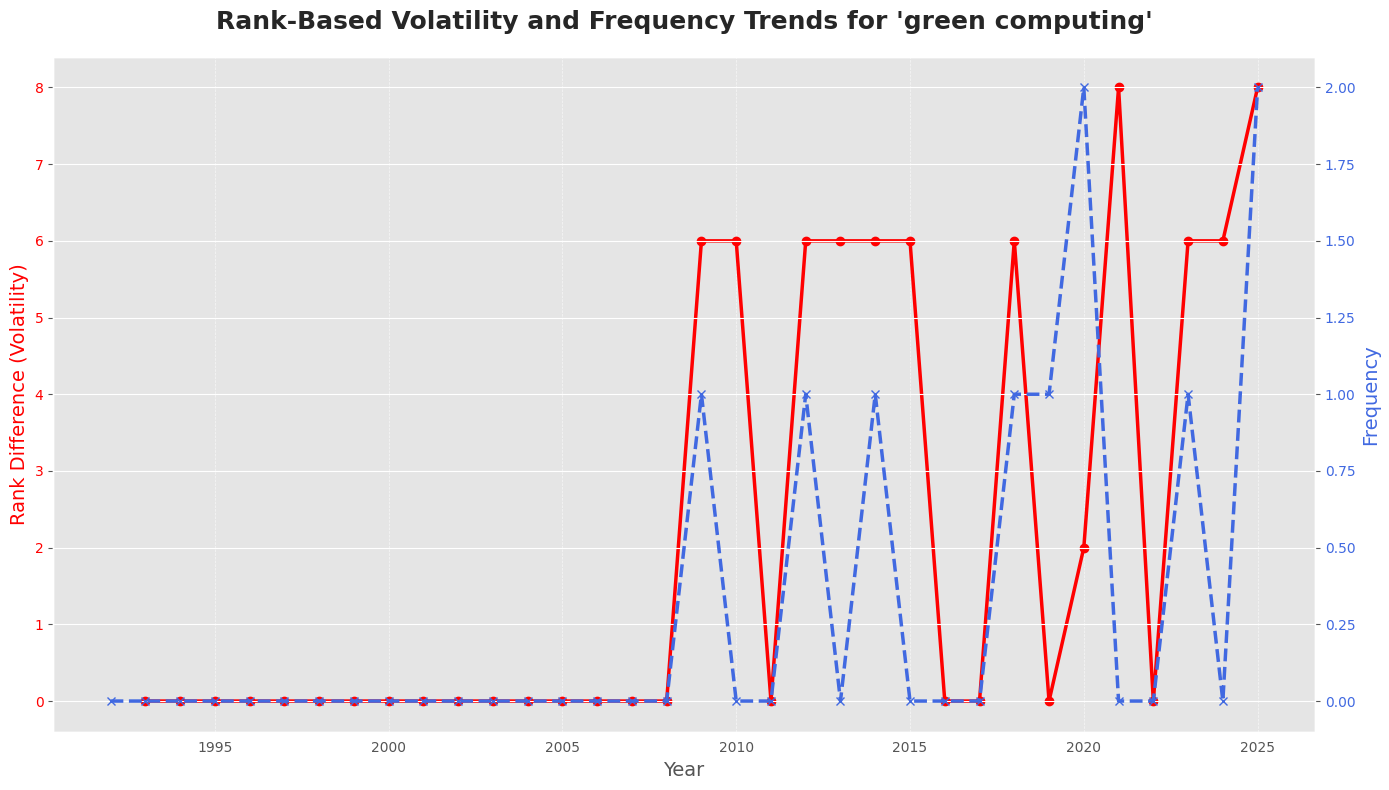

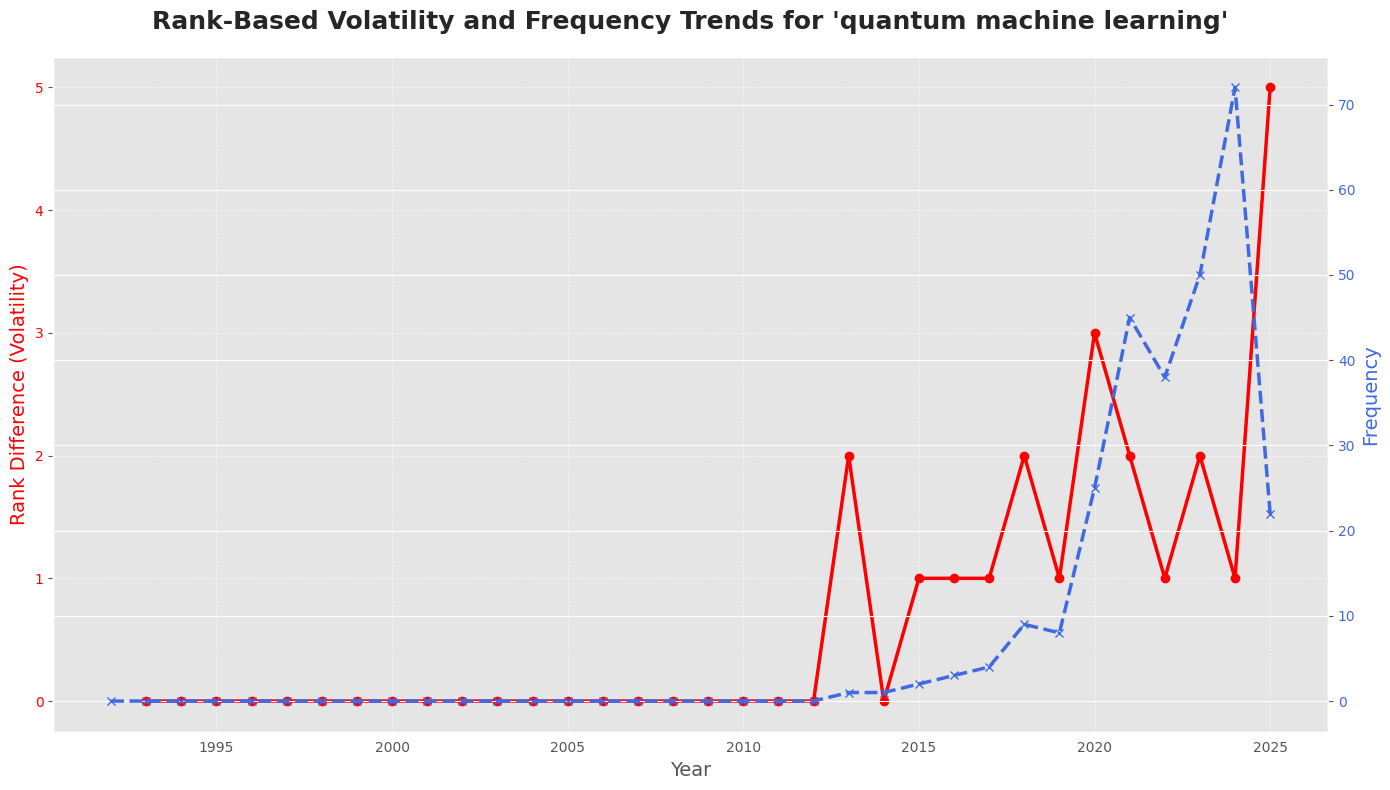

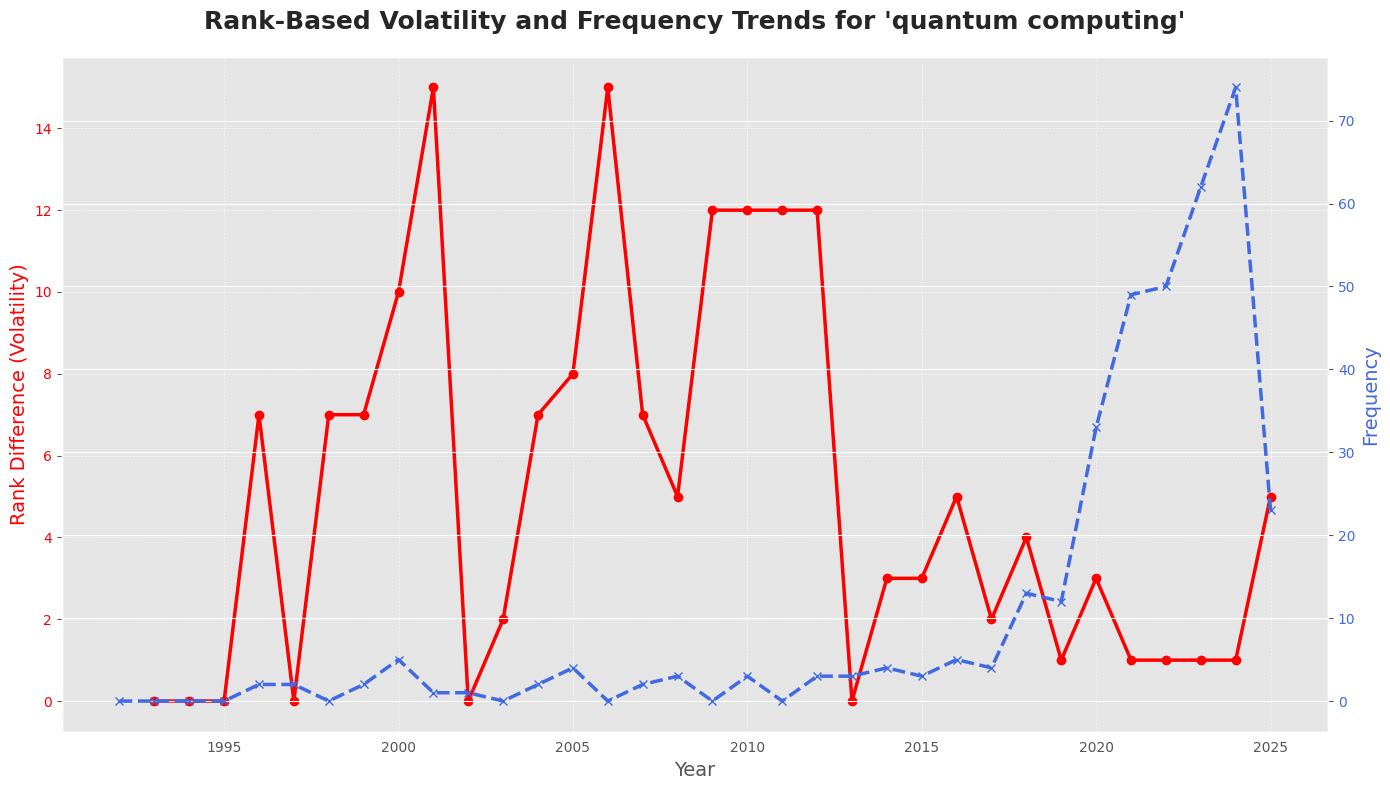

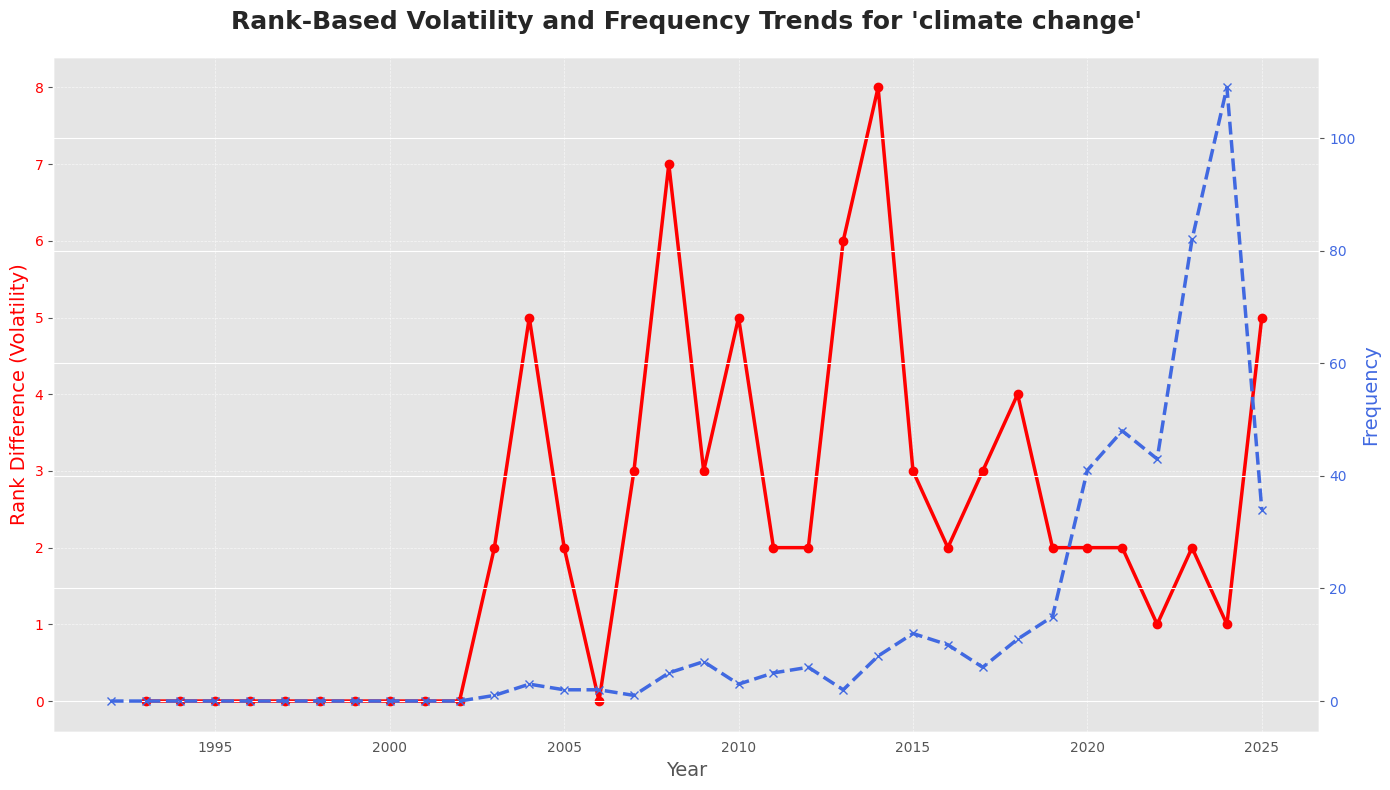

In [101]:
import matplotlib.pyplot as plt

# Set style globally (safe style that works well and is widely available)
plt.style.use("ggplot")

def improved_plot_rank_based_volatility(term, term_frequencies_df):
    ranks = term_frequencies_df[term].rank(method="min", ascending=False)
    rank_diff = ranks.diff().abs()

    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Left y-axis: Volatility (Rank Difference)
    ax1.plot(
        rank_diff.index,
        rank_diff.values,
        marker='o',
        color='red',
        linewidth=2.5,
        label=f"{term} Volatility"
    )
    ax1.set_xlabel("Year", fontsize=14)
    ax1.set_ylabel("Rank Difference (Volatility)", fontsize=14, color='red')
    ax1.tick_params(axis='y', labelcolor='red')
    ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Right y-axis: Frequency
    ax2 = ax1.twinx()
    ax2.plot(
        term_frequencies_df[term].index,
        term_frequencies_df[term].values,
        marker='x',
        linestyle='--',
        color='royalblue',
        linewidth=2.5,
        label=f"{term} Frequency"
    )
    ax2.set_ylabel("Frequency", fontsize=14, color='royalblue')
    ax2.tick_params(axis='y', labelcolor='royalblue')



    # Title and layout
    plt.title(
        f"Rank-Based Volatility and Frequency Trends for '{term}'",
        fontsize=18,
        fontweight='bold',
        pad=20
    )

    plt.tight_layout()
    plt.show()

# Call the function for each term
for term in terms_of_interest:
    improved_plot_rank_based_volatility(term, term_frequencies_df)


In [106]:
# Calculate percentile-based thresholds for frequency
frequency_percentile = term_frequencies_df.mean().quantile(0.2)  # Lower percentile for weak signal detection


weak_signals = []

for term in terms_of_interest:
    term_frequency = term_frequencies_df[term]
    ranks = term_frequency.rank(method="min", ascending=False)
    rank_diff = ranks.diff().abs()
    rank_based_volatility = rank_diff.mean()

    avg_frequency = term_frequency.mean()

    print(f"Term: {term}")
    print(f"  Average Frequency: {avg_frequency}")
    print(f"  Rank-Based Volatility: {rank_based_volatility}")

    # Detect weak signals based on adjusted criteria
    if rank_based_volatility > 2:
        weak_signals.append({
            "Term": term,
            "Average Frequency": avg_frequency,
            "Rank-Based Volatility": rank_based_volatility
        })

weak_signals_df = pd.DataFrame(weak_signals)

print("\nWeak Signals Detected:")
print(weak_signals_df)

Term: federated learning
  Average Frequency: 6.176470588235294
  Rank-Based Volatility: 0.48484848484848486
Term: edge computing
  Average Frequency: 7.647058823529412
  Rank-Based Volatility: 0.7575757575757576
Term: synthetic biology
  Average Frequency: 6.411764705882353
  Rank-Based Volatility: 1.7575757575757576
Term: digital twins
  Average Frequency: 0.08823529411764706
  Rank-Based Volatility: 0.18181818181818182
Term: emotion recognition
  Average Frequency: 11.617647058823529
  Rank-Based Volatility: 1.1515151515151516
Term: autonomous vehicles
  Average Frequency: 0.0
  Rank-Based Volatility: 0.0
Term: green computing
  Average Frequency: 0.29411764705882354
  Rank-Based Volatility: 2.1818181818181817
Term: quantum machine learning
  Average Frequency: 8.235294117647058
  Rank-Based Volatility: 0.6666666666666666
Term: quantum computing
  Average Frequency: 10.735294117647058
  Rank-Based Volatility: 5.090909090909091
Term: climate change
  Average Frequency: 13.41176470588

In [107]:
print(weak_signals_df.columns)

Index(['Term', 'Average Frequency', 'Rank-Based Volatility'], dtype='object')


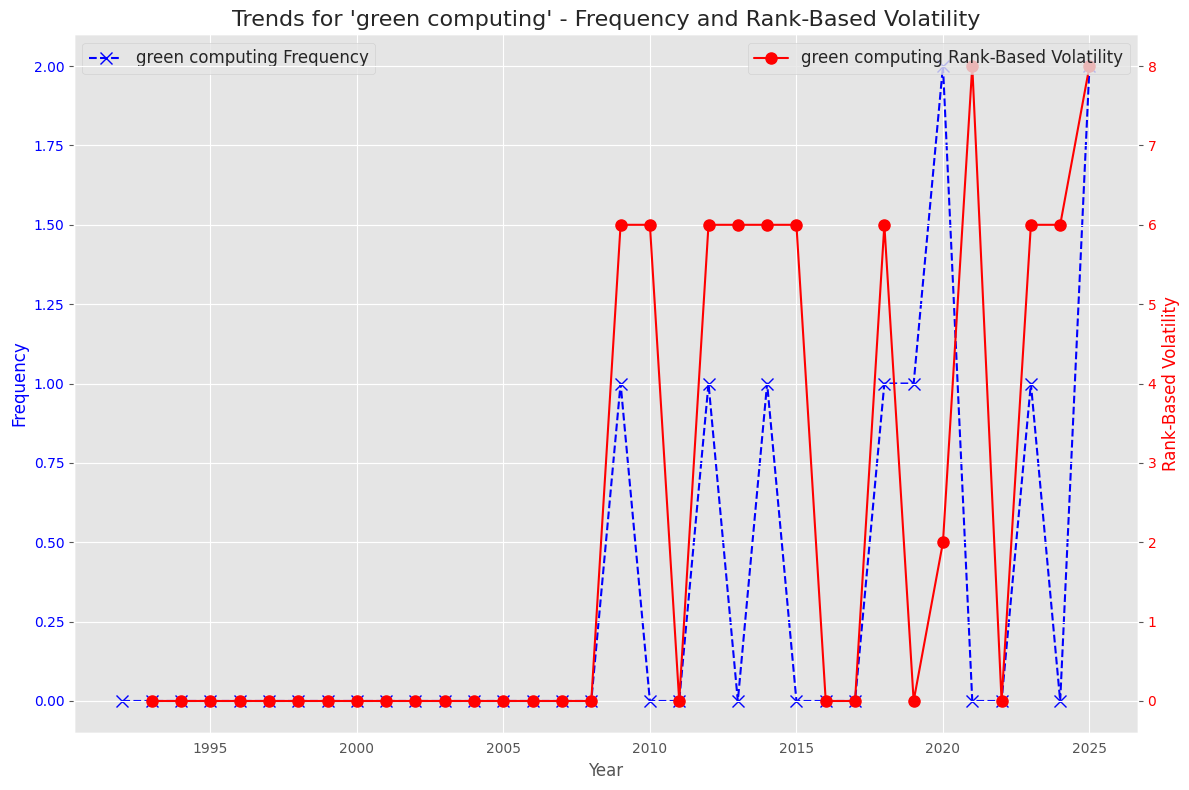

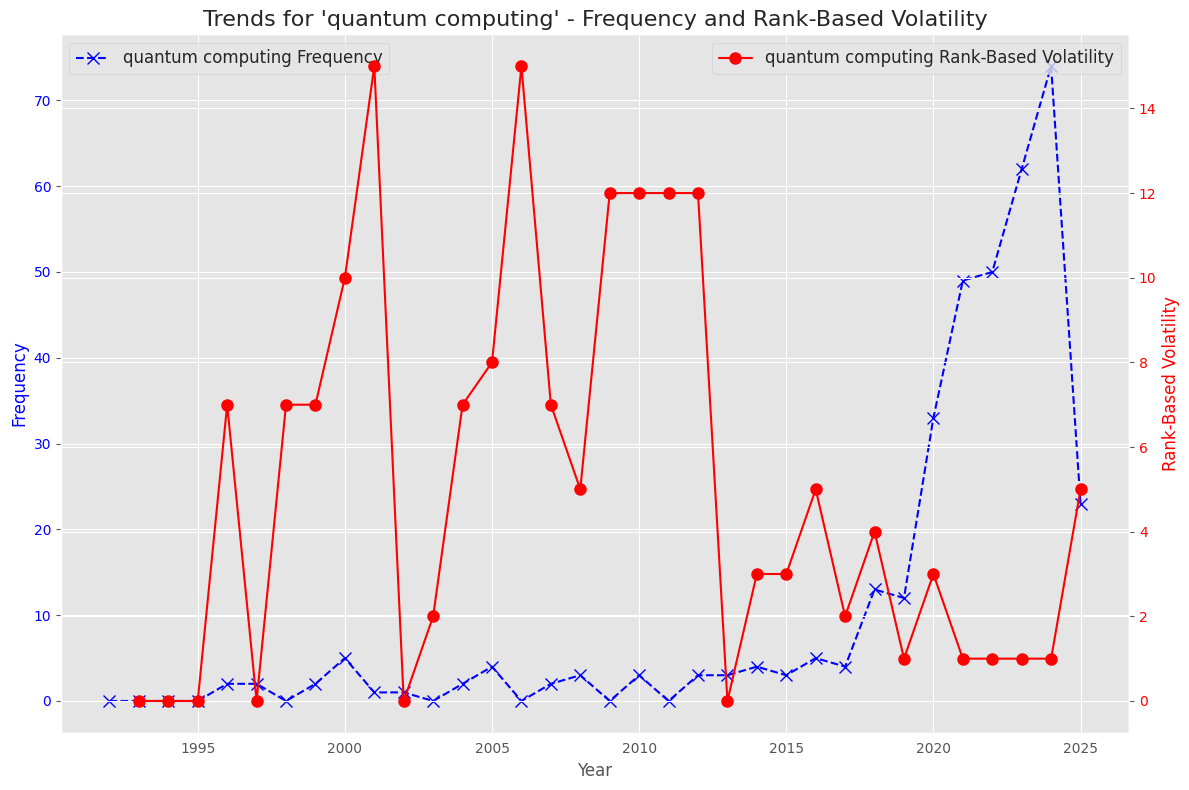

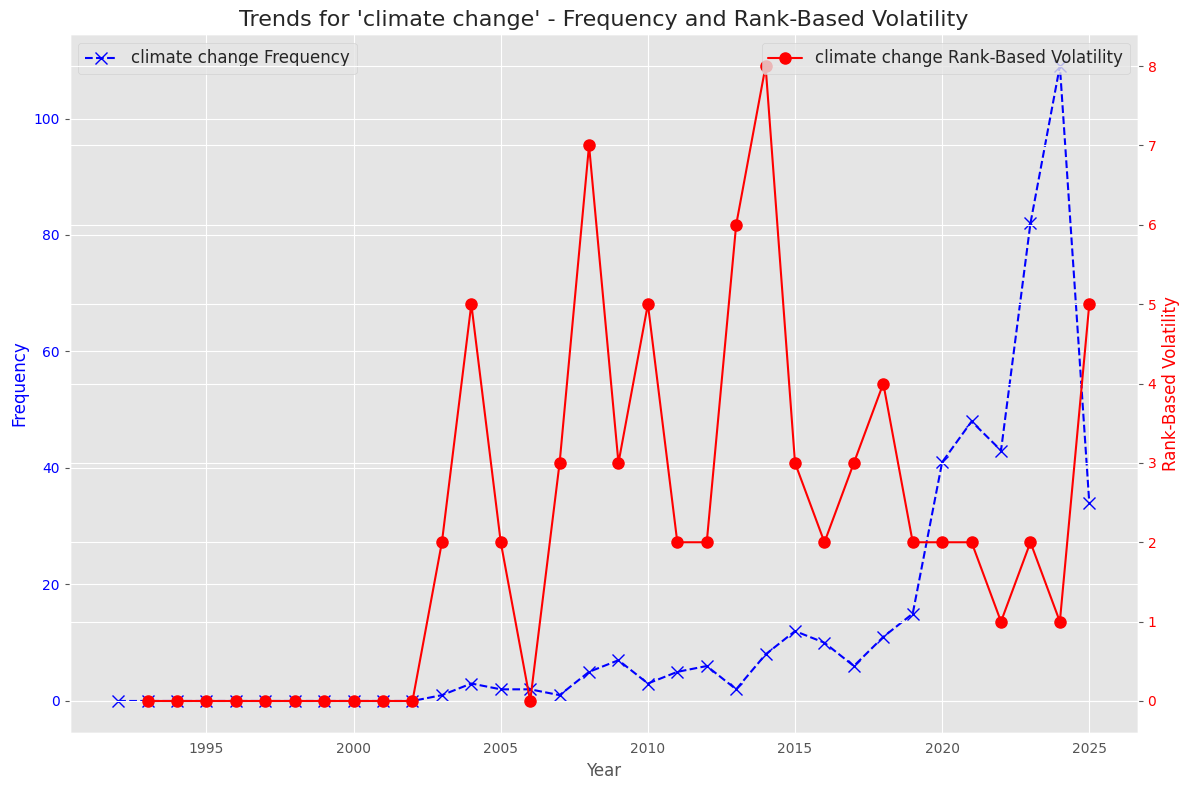

In [111]:
import matplotlib.pyplot as plt

def plot_weak_signal_trends(weak_signals, term_frequencies_df):
    for term in weak_signals['Term']:
        term_data = term_frequencies_df[term]
        rank_volatility = term_data.rank(method="min", ascending=False).diff().abs()

        fig, ax1 = plt.subplots(figsize=(12, 8))


        ax1.plot(term_data.index, term_data.values, 'b--x', label=f"{term} Frequency", markersize=8)
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Frequency', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')


        ax2 = ax1.twinx()
        ax2.plot(rank_volatility.index, rank_volatility.values, 'r-o', label=f"{term} Rank-Based Volatility", markersize=8)
        ax2.set_ylabel('Rank-Based Volatility', color='red')
        ax2.tick_params(axis='y', labelcolor='red')


        plt.title(f"Trends for '{term}' - Frequency and Rank-Based Volatility", fontsize=16)
        ax1.grid(True)


        ax1.legend(loc='upper left', fontsize=12)
        ax2.legend(loc='upper right', fontsize=12)


        plt.tight_layout()
        plt.show()


plot_weak_signal_trends(weak_signals_df, term_frequencies_df)


In [112]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


term = 'quantum computing'
data = term_frequencies_df[term].values
data = data.reshape(-1, 1)

scaler_freq = MinMaxScaler(feature_range=(0, 1))

scaled_data = scaler_freq.fit_transform(data)

# Prepare the data for LSTM
look_back = 5

def create_dataset(data, look_back=1):
    x, y = [], []
    for i in range(len(data) - look_back):
        x.append(data[i:i + look_back, 0])
        y.append(data[i + look_back, 0])
    return np.array(x), np.array(y)

x_data, y_data = create_dataset(scaled_data, look_back)


x_data = np.reshape(x_data, (x_data.shape[0], x_data.shape[1], 1))


In [113]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define the LSTM model
def create_model():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=False, input_shape=(x_data.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create and train the model
model = create_model()
model.fit(x_data, y_data, epochs=50, batch_size=32, verbose=1)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.0949
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0895
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0843
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0794
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0749
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0706
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0667
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0630
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0597
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.0567
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0541
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0517
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0497
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0481
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0467
Epoch 16/50
1/1 ━━━━━━━━━━━

In [114]:
# Function to make future predictions
def predict_future(model, data, look_back, steps=5):
    predictions = []
    last_data = data[-look_back:].reshape(1, look_back, 1)  # Get the last 5 data points

    for _ in range(steps):
        pred = model.predict(last_data)
        predictions.append(pred[0][0])
        last_data = np.roll(last_data, -1, axis=1)  # Shift the data
        last_data[0, -1, 0] = pred  # Add the new prediction

    return np.array(predictions)

# Make predictions for the next 5 years
future_freq = predict_future(model, scaled_data, look_back, steps=5)

# Inverse transform the predictions to get the original scale
future_freq = scaler_freq.inverse_transform(future_freq.reshape(-1, 1))

# Print the future frequency predictions
print("Predicted Frequencies for next 5 years:")
for year, freq in zip(range(2025, 2030), future_freq.flatten()):
    print(f"Year {year}: Predicted Frequency: {freq:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


<ipython-input-114-ece0a20e2a08>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted Frequencies for next 5 years:
Year 2025: Predicted Frequency: 63.78
Year 2026: Predicted Frequency: 65.84
Year 2027: Predicted Frequency: 68.92
Year 2028: Predicted Frequency: 70.45
Year 2029: Predicted Frequency: 70.27


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


<ipython-input-117-53e9d76777da>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step

Predicted Frequencies for 'federated learning' for the next 5 years:
Year 2025: Predicted Frequency: 39.73
Year 2026: Predicted Frequency: 40.00
Year 2027: Predicted Frequency: 39.89
Year 2028: Predicted Frequency: 39.14
Year 2029: Predicted Frequency: 40.87


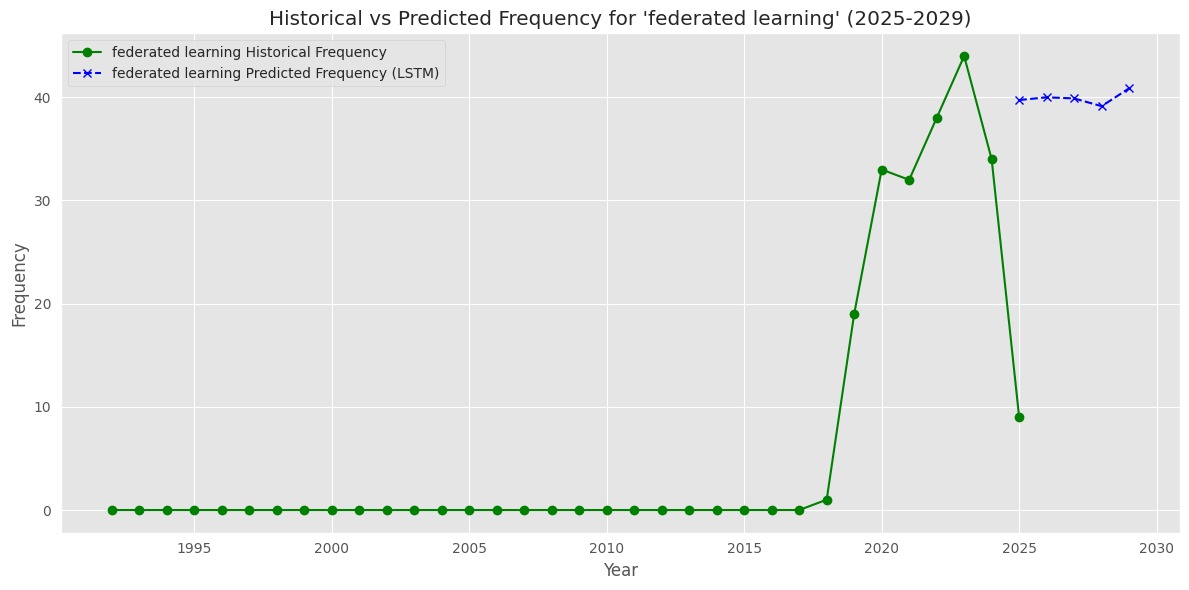

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


<ipython-input-117-53e9d76777da>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step

Predicted Frequencies for 'edge computing' for the next 5 years:
Year 2025: Predicted Frequency: 39.67
Year 2026: Predicted Frequency: 36.07
Year 2027: Predicted Frequency: 37.88
Year 2028: Predicted Frequency: 39.57
Year 2029: Predicted Frequency: 41.33


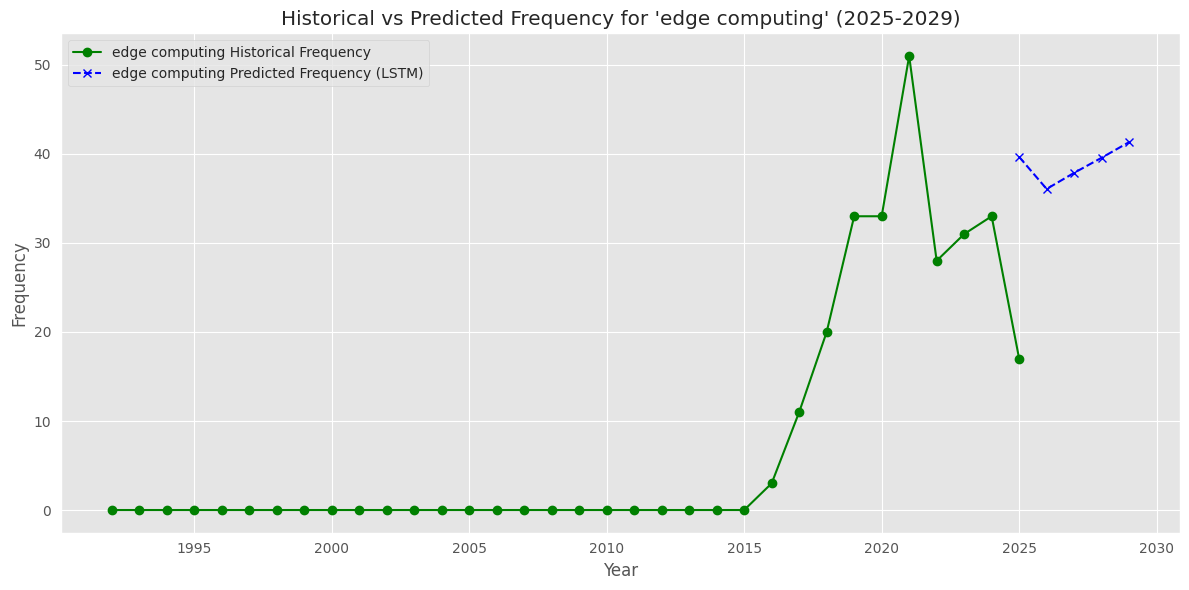

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


<ipython-input-117-53e9d76777da>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

Predicted Frequencies for 'synthetic biology' for the next 5 years:
Year 2025: Predicted Frequency: 21.26
Year 2026: Predicted Frequency: 20.05
Year 2027: Predicted Frequency: 21.08
Year 2028: Predicted Frequency: 22.66
Year 2029: Predicted Frequency: 23.39


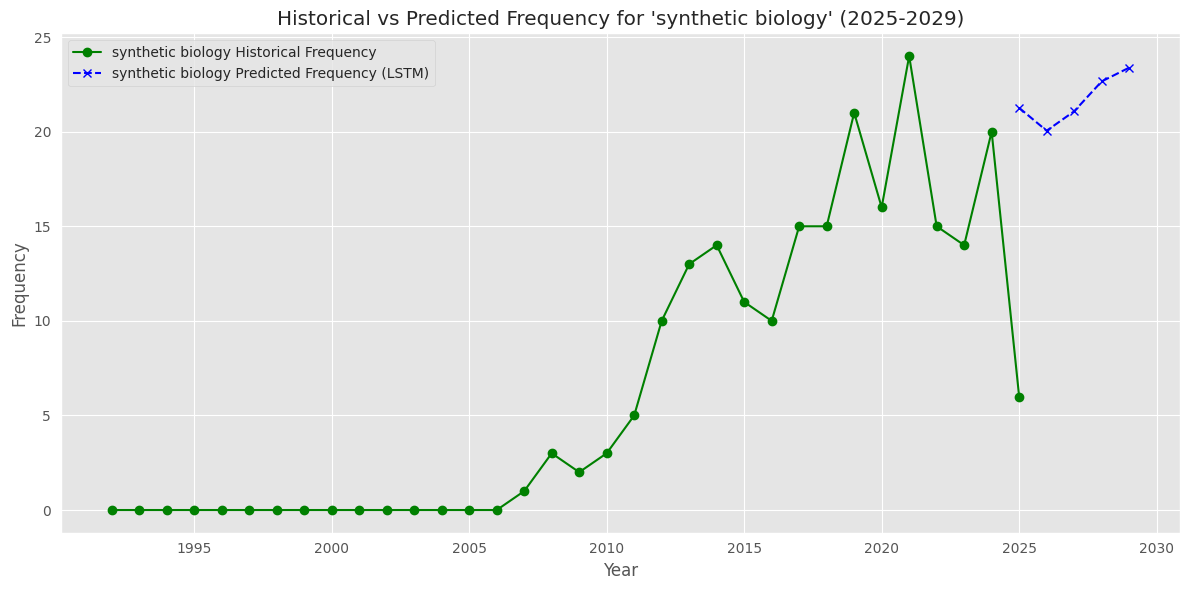

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


<ipython-input-117-53e9d76777da>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

Predicted Frequencies for 'digital twins' for the next 5 years:
Year 2025: Predicted Frequency: 4.96
Year 2026: Predicted Frequency: 5.77
Year 2027: Predicted Frequency: 6.72
Year 2028: Predicted Frequency: 8.12
Year 2029: Predicted Frequency: 9.41


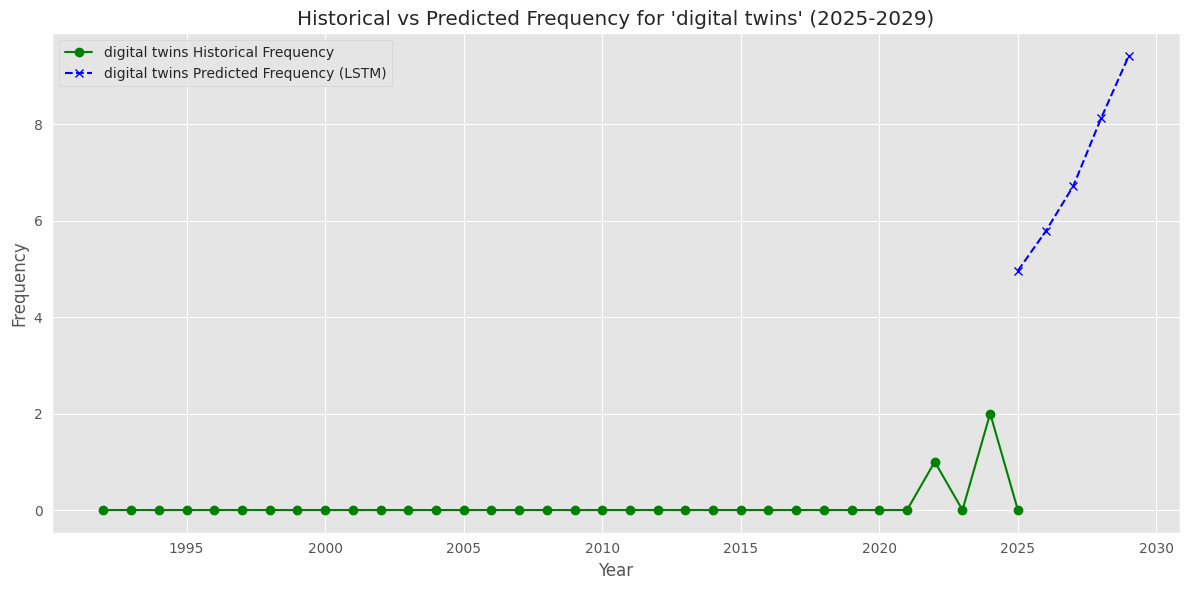

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

<ipython-input-117-53e9d76777da>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

Predicted Frequencies for 'emotion recognition' for the next 5 years:
Year 2025: Predicted Frequency: 66.19
Year 2026: Predicted Frequency: 71.67
Year 2027: Predicted Frequency: 75.40
Year 2028: Predicted Frequency: 78.35
Year 2029: Predicted Frequency: 77.33


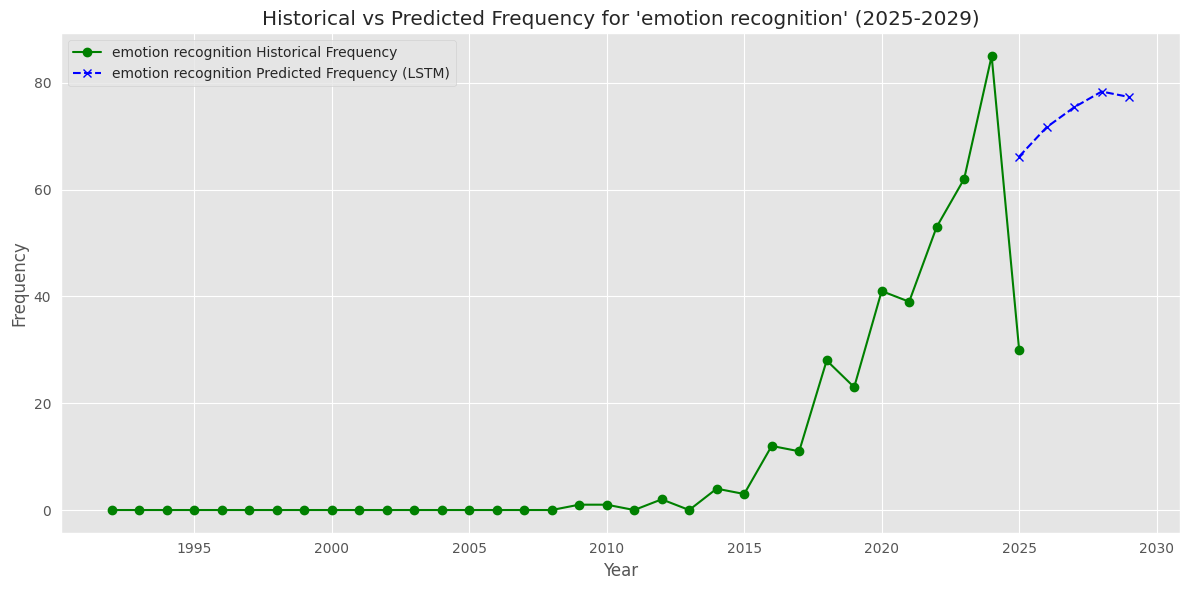

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


<ipython-input-117-53e9d76777da>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

Predicted Frequencies for 'autonomous vehicles' for the next 5 years:
Year 2025: Predicted Frequency: 4.34
Year 2026: Predicted Frequency: 5.03
Year 2027: Predicted Frequency: 6.03
Year 2028: Predicted Frequency: 7.30
Year 2029: Predicted Frequency: 8.82


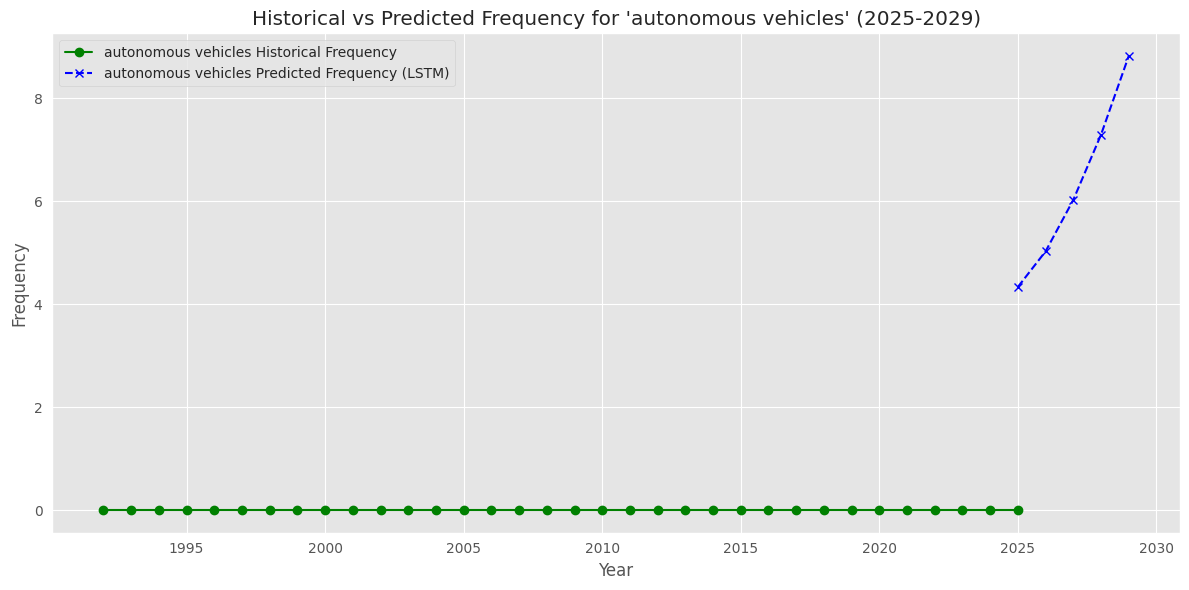

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


<ipython-input-117-53e9d76777da>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

Predicted Frequencies for 'green computing' for the next 5 years:
Year 2025: Predicted Frequency: 4.87
Year 2026: Predicted Frequency: 5.74
Year 2027: Predicted Frequency: 6.90
Year 2028: Predicted Frequency: 8.15
Year 2029: Predicted Frequency: 9.85


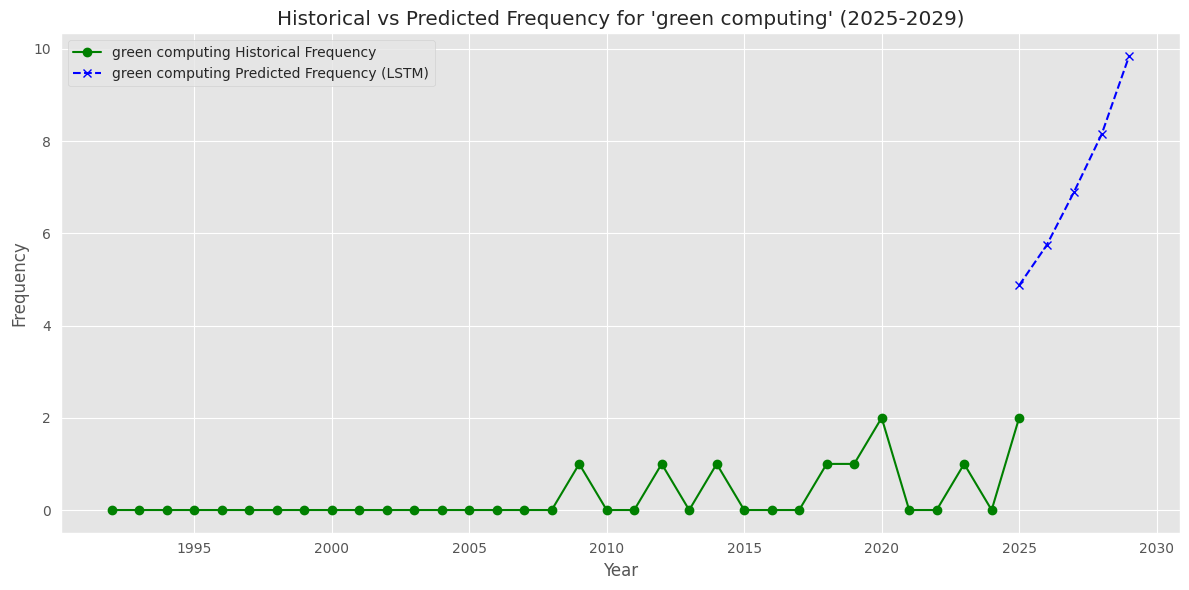

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

<ipython-input-117-53e9d76777da>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

Predicted Frequencies for 'quantum machine learning' for the next 5 years:
Year 2025: Predicted Frequency: 55.90
Year 2026: Predicted Frequency: 57.50
Year 2027: Predicted Frequency: 61.62
Year 2028: Predicted Frequency: 64.13
Year 2029: Predicted Frequency: 62.74


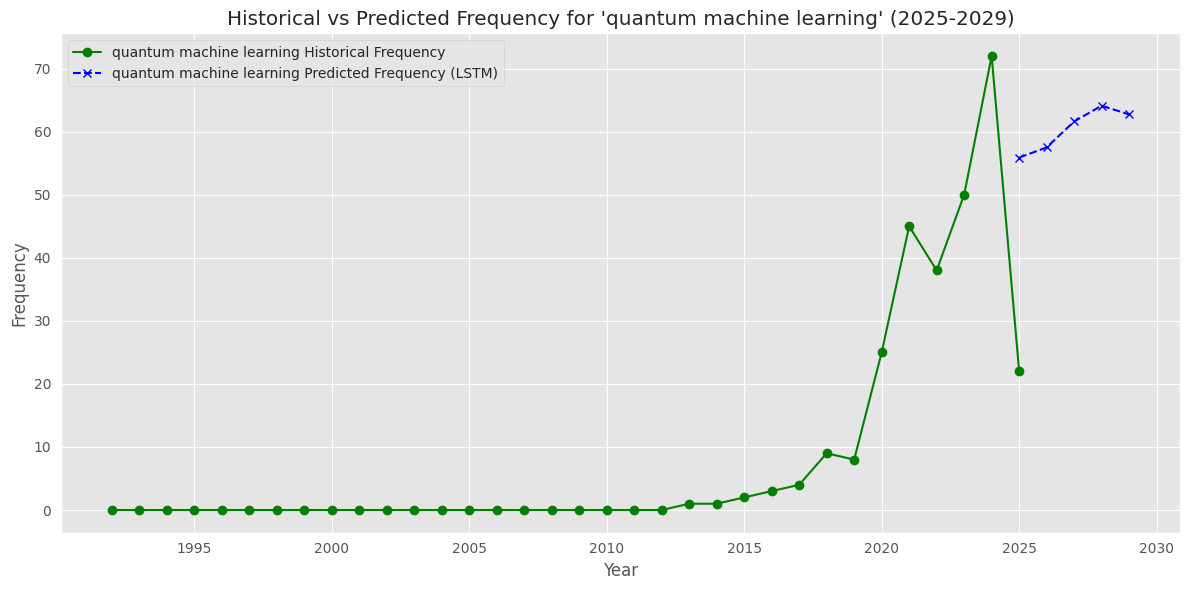

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


<ipython-input-117-53e9d76777da>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step

Predicted Frequencies for 'climate change' for the next 5 years:
Year 2025: Predicted Frequency: 77.61
Year 2026: Predicted Frequency: 83.93
Year 2027: Predicted Frequency: 92.84
Year 2028: Predicted Frequency: 94.75
Year 2029: Predicted Frequency: 92.08


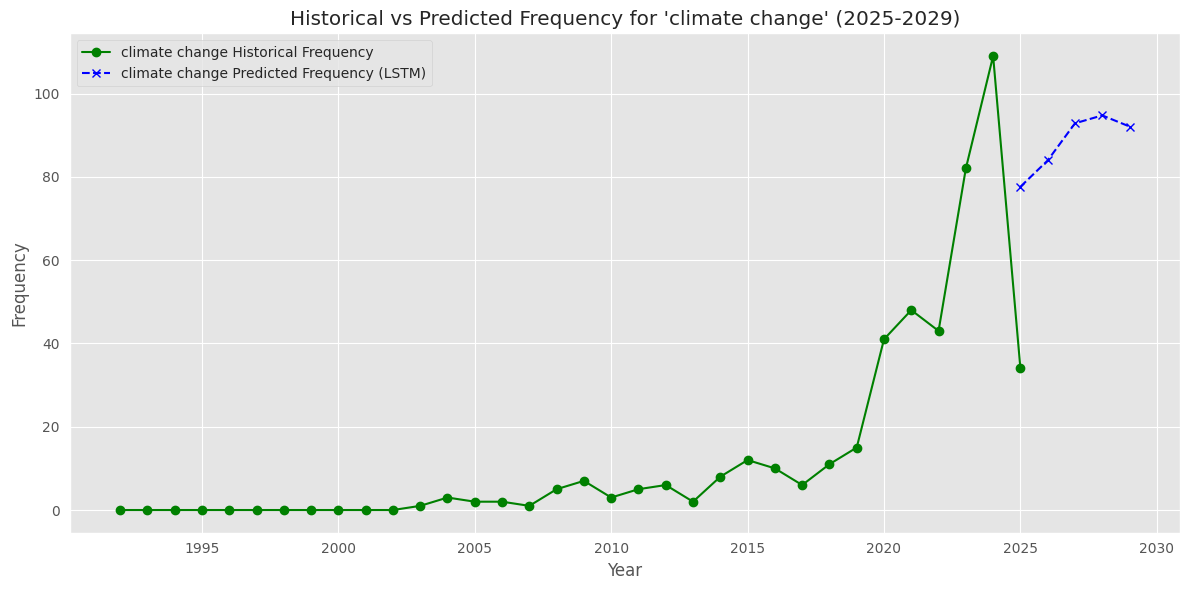

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

<ipython-input-117-53e9d76777da>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step

Predicted Frequencies for 'quantum computing' for the next 5 years:
Year 2025: Predicted Frequency: 63.78
Year 2026: Predicted Frequency: 65.84
Year 2027: Predicted Frequency: 68.92
Year 2028: Predicted Frequency: 70.45
Year 2029: Predicted Frequency: 70.27


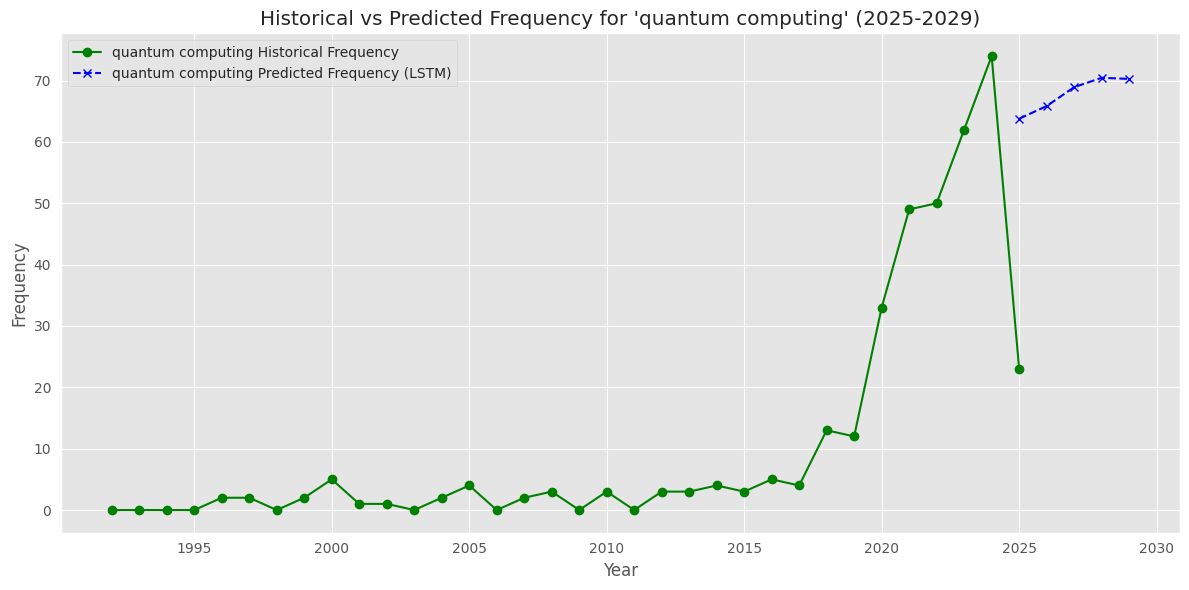

In [117]:
import numpy as np
import matplotlib.pyplot as plt

# Function to make future predictions
def predict_future(model, data, look_back, steps=5):
    predictions = []
    last_data = data[-look_back:].reshape(1, look_back, 1)  # Get the last 'look_back' data points

    for _ in range(steps):
        pred = model.predict(last_data)
        predictions.append(pred[0][0])
        last_data = np.roll(last_data, -1, axis=1)  # Shift the data
        last_data[0, -1, 0] = pred  # Add the new prediction

    return np.array(predictions)

# Function to display the predictions for each term
def display_predictions_for_all_terms(terms_of_interest, term_frequencies_df, model, scaler_freq, look_back=5, steps=5):
    # Filter out terms not present in term_frequencies_df
    valid_terms = [term for term in terms_of_interest if term in term_frequencies_df.columns]

    for term in valid_terms:

        historical_data = term_frequencies_df[term].values


        scaled_data = scaler_freq.transform(historical_data.reshape(-1, 1))


        future_freq = predict_future(model, scaled_data, look_back, steps=steps)

        future_freq = scaler_freq.inverse_transform(future_freq.reshape(-1, 1))


        print(f"\nPredicted Frequencies for '{term}' for the next 5 years:")
        for year, freq in zip(range(2025, 2030), future_freq.flatten()):
            print(f"Year {year}: Predicted Frequency: {freq:.2f}")

        # Plotting the results
        plt.figure(figsize=(12, 6))
        plt.plot(term_frequencies_df[term].index, term_frequencies_df[term].values, label=f'{term} Historical Frequency', color='green', marker='o')
        plt.plot(range(2025, 2030), future_freq.flatten(), linestyle='--', color='blue', marker='x', label=f'{term} Predicted Frequency (LSTM)')
        plt.title(f"Historical vs Predicted Frequency for '{term}' (2025-2029)")
        plt.xlabel('Year')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

# List of terms to predict
terms_of_interest = [
   "graph neural networks",
    "explainable AI",
    "federated learning",
    "edge computing",
    "synthetic biology",
    "digital twins",
    "biomedical informatics",
    "CRISPR gene editing",
    "blockchain in healthcare",
    "emotion recognition",
    "autonomous vehicles",
    "green computing",
    "AI ethics in medicine",
    "AI in education",
    "quantum machine learning",
    "computational sustainability",
    "climate change",
    "quantum computing"
]


display_predictions_for_all_terms(terms_of_interest, term_frequencies_df, model, scaler_freq, look_back=5, steps=5)


In [118]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def preprocess_volatility_for_lstm(df, term, look_back=5):
    # Use the rank-based volatility data for the term
    volatility_data = df[term].rank(method="min", ascending=False).diff().abs().values
    volatility_data = volatility_data.reshape(-1, 1)

    # Scale the volatility data
    scaler_vol = MinMaxScaler(feature_range=(0, 1))
    scaled_volatility = scaler_vol.fit_transform(volatility_data)


    x_data_vol = []
    y_data_vol = []

    for i in range(look_back, len(scaled_volatility)):
        x_data_vol.append(scaled_volatility[i-look_back:i, 0])  # Previous 'look_back' values
        y_data_vol.append(scaled_volatility[i, 0])  # Next value to predict

    x_data_vol = np.array(x_data_vol)
    y_data_vol = np.array(y_data_vol)

    x_data_vol = np.reshape(x_data_vol, (x_data_vol.shape[0], x_data_vol.shape[1], 1))

    return x_data_vol, y_data_vol, scaler_vol


In [120]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


term = 'quantum computing'
x_data_vol, y_data_vol, scaler_vol = preprocess_volatility_for_lstm(term_frequencies_df, term)

# Create and train the LSTM model
model_vol = create_lstm_model(input_shape=(x_data_vol.shape[1], 1))
model_vol.fit(x_data_vol, y_data_vol, epochs=50, batch_size=32)

# Save the trained model
model_vol.save(f"{term}_rank_based_volatility_lstm_model.h5")


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: nan
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: nan
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: nan
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: nan
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: nan
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: nan
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: nan
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: nan
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: nan
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: nan
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: nan
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: nan
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: nan
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: nan
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: nan
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: nan
Epoch 17/50


In [122]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np


def create_dataset(data, look_back=1):
    x, y = [], []
    for i in range(len(data) - look_back):
        x.append(data[i:i + look_back, 0])
        y.append(data[i + look_back, 0])
    return np.array(x), np.array(y)


terms_of_interest = [
   "graph neural networks",
    "explainable AI",
    "federated learning",
    "edge computing",
    "synthetic biology",
    "digital twins",
    "biomedical informatics",
    "CRISPR gene editing",
    "blockchain in healthcare",
    "emotion recognition",
    "autonomous vehicles",
    "green computing",
    "AI ethics in medicine",
    "AI in education",
    "quantum machine learning",
    "computational sustainability",
    "climate change",
    "quantum computing"
]


scaler_vol = MinMaxScaler(feature_range=(0, 1))

x_data_all = {}
y_data_all = {}
models = {}


look_back = 5
valid_terms = [term for term in terms_of_interest if term in term_frequencies_df.columns]
for term in valid_terms:

    volatility_data = term_frequencies_df[term].rank(method="min", ascending=False).diff().abs()


    volatility_data = volatility_data.dropna().values.reshape(-1, 1)


    scaled_volatility = scaler_vol.fit_transform(volatility_data)

    # Prepare the dataset for LSTM
    x_data, y_data = create_dataset(scaled_volatility, look_back)


    x_data = np.reshape(x_data, (x_data.shape[0], x_data.shape[1], 1))


    x_data_all[term] = x_data
    y_data_all[term] = y_data


In [124]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Function to create and train the LSTM model
def create_and_train_lstm(x_data, y_data, epochs=50, batch_size=8):
    model = Sequential()
    model.add(LSTM(50, return_sequences=False, input_shape=(x_data.shape[1], 1)))  # LSTM layer
    model.add(Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(x_data, y_data, epochs=epochs, batch_size=batch_size, verbose=0)

    return model
valid_terms = [term for term in terms_of_interest if term in term_frequencies_df.columns]
# Train the LSTM model for each term and store the models
for term in valid_terms:
    print(f"Training LSTM model for {term}...")
    model = create_and_train_lstm(x_data_all[term], y_data_all[term])
    models[term] = model


Training LSTM model for federated learning...
Training LSTM model for edge computing...
Training LSTM model for synthetic biology...
Training LSTM model for digital twins...
Training LSTM model for emotion recognition...
Training LSTM model for autonomous vehicles...
Training LSTM model for green computing...
Training LSTM model for quantum machine learning...
Training LSTM model for climate change...
Training LSTM model for quantum computing...


In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

def create_dataset(data, look_back=1):
    x, y = [], []
    for i in range(len(data) - look_back):
        x.append(data[i:i + look_back, 0])
        y.append(data[i + look_back, 0])
    return np.array(x), np.array(y)

terms_of_interest = [
    "graph neural networks", "explainable AI", "federated learning", "edge computing",
    "synthetic biology", "digital twins", "biomedical informatics", "CRISPR gene editing",
    "blockchain in healthcare", "emotion recognition", "autonomous vehicles", "green computing",
    "AI ethics in medicine", "AI in education", "quantum machine learning",
    "computational sustainability", "climate change", "quantum computing"
]

scaler_vol = MinMaxScaler(feature_range=(0, 1))
look_back = 5

# Store features for clustering
feature_vectors = []
term_labels = []

valid_terms = [term for term in terms_of_interest if term in term_frequencies_df.columns]

for term in valid_terms:
    # Calculate volatility
    volatility_data = term_frequencies_df[term].rank(method="min", ascending=False).diff().abs().dropna().values.reshape(-1, 1)

    # Normalize
    scaled_volatility = scaler_vol.fit_transform(volatility_data)

    # Extract basic features: mean, std, and trend
    mean_vol = np.mean(scaled_volatility)
    std_vol = np.std(scaled_volatility)
    trend_vol = np.polyfit(range(len(scaled_volatility)), scaled_volatility.flatten(), 1)[0]  # slope

    feature_vectors.append([mean_vol, std_vol, trend_vol])
    term_labels.append(term)

# Perform K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(feature_vectors)

# Create a DataFrame for visualization
cluster_df = pd.DataFrame({
    'Term': term_labels,
    'Cluster': clusters
})


In [126]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=False, input_shape=input_shape))
    model.add(Dense(1))  # Output layer with a single neuron
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


models = {}
valid_terms = [term for term in terms_of_interest if term in term_frequencies_df.columns]
for term in valid_terms:
    print(f"Training model for {term}...")

    # Build LSTM model
    model = build_lstm_model((x_data_all[term].shape[1], 1))

    # Train the model
    model.fit(x_data_all[term], y_data_all[term], epochs=100, batch_size=16, verbose=1)

    # Store the trained model
    models[term] = model

# Once training is complete, you can print the models or check their summary
for term in models:
    print(f"Model trained for {term}")
    models[term].summary()


Training model for federated learning...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 0.0740
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0735
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0460
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0429
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0571
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0385
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0469
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0309
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0470
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0339 
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0362
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0344
Epoch 13/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0400
Epoch 14/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0323 
Epoch 15/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

Model trained for edge computing


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

Model trained for synthetic biology


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

Model trained for digital twins


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

Model trained for emotion recognition


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

Model trained for autonomous vehicles


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

Model trained for green computing


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                  │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

Model trained for quantum machine learning


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

Model trained for climate change


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                  │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

Model trained for quantum computing


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                  │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

In [128]:
import numpy as np

# Check for NaNs or infs
print("NaNs in input data:", np.isnan(x_data_vol).any())
print("Infs in input data:", np.isinf(x_data_vol).any())


NaNs in input data: True
Infs in input data: False


In [141]:
import numpy as np

def predict_future_volatility(model, data, look_back, steps=5):
    last_data = data[-look_back:].reshape(1, look_back, 1)
    pred_test = model_vol.predict(last_data)
    print("Direct prediction:", pred_test)


    predictions = []

    # Check if the data has enough elements for look_back
    if len(data) < look_back:
        raise ValueError(f"Data length ({len(data)}) is smaller than look_back ({look_back})")

    # Ensure the data is a 2D array (samples, 1)
    data = np.array(data).reshape(-1, 1)  # Reshaping data to (n_samples, 1) if it's 1D

    last_data = data[-look_back:].reshape(1, look_back, 1)  # Reshape the last 'look_back' elements to (1, look_back, 1)

    for _ in range(steps):
        pred = model.predict(last_data)
        predictions.append(pred[0][0])  # Take the prediction value
        last_data = np.roll(last_data, -1, axis=1)  # Shift the data by one step
        last_data[0, -1, 0] = pred  # Add the new prediction

    return np.array(predictions)

# Example usage:
look_back = 5  # Number of previous time steps to look back
steps = 5      # Number of future steps to predict

# Assuming `model_vol` is your trained model and `x_data_vol` is the input data
try:
    future_vol = predict_future_volatility(model_vol, x_data_vol, look_back, steps)

    # If scaler is defined for inverse transformation
    future_vol = scaler_vol.inverse_transform(future_vol.reshape(-1, 1))

    # Print the future volatility predictions
    print("Predicted Rank-Based Volatility for the next 5 years:")
    for year, vol in zip(range(2025, 2030), future_vol.flatten()):
        print(f"Year {year}: Predicted Rank-Based Volatility: {vol:.2f}")
except ValueError as e:
    print(e)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Direct prediction: [[nan]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


<ipython-input-141-8190241af632>:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Predicted Rank-Based Volatility for the next 5 years:
Year 2025: Predicted Rank-Based Volatility: nan
Year 2026: Predicted Rank-Based Volatility: nan
Year 2027: Predicted Rank-Based Volatility: nan
Year 2028: Predicted Rank-Based Volatility: nan
Year 2029: Predicted Rank-Based Volatility: nan


In [143]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Function to build the LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=False, input_shape=input_shape))
    model.add(Dense(1))  # Output layer with a single neuron
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Function to make future predictions for volatility
def predict_future_volatility(model, data, look_back, steps=5):
    predictions = []

    # Ensure data is correctly reshaped for LSTM input
    data = np.array(data).reshape(-1, 1)  # Reshaping data to (n_samples, 1)

    # Take the last 'look_back' points to make the first prediction
    last_data = data[-look_back:].reshape(1, look_back, 1)  # Reshaped as (1, look_back, 1)

    for _ in range(steps):
        pred = model.predict(last_data)
        predictions.append(pred[0][0])  # Extract the scalar prediction
        last_data = np.roll(last_data, -1, axis=1)  # Shift the data by one step
        last_data[0, -1, 0] = pred  # Add the new prediction

    return np.array(predictions)

# Train and predict for each term
models = {}
predictions_all_terms = {}
valid_terms = [term for term in terms_of_interest if term in term_frequencies_df.columns]
for term in valid_terms:
    print(f"Training model for {term}...")

    model = build_lstm_model((x_data_all[term].shape[1], 1))


    model.fit(x_data_all[term], y_data_all[term], epochs=100, batch_size=16, verbose=1)


    models[term] = model

    # Predict the future volatility for this term (next 5 years)
    future_vol = predict_future_volatility(model, x_data_all[term], look_back=5, steps=5)

    future_vol = scaler_vol.inverse_transform(future_vol.reshape(-1, 1))

    # Store the predictions for this term
    predictions_all_terms[term] = future_vol

    print(f"Predicted Rank-Based Volatility for {term} for the next 5 years:")
    for year, vol in zip(range(2025, 2030), future_vol.flatten()):
        print(f"Year {year}: Predicted Rank-Based Volatility: {vol:.2f}")

for term in models:
    print(f"Model trained for {term}")
    models[term].summary()


Training model for federated learning...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.0726
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0856
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.0897
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0687 
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.0622
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0538 
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0617 
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0456
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.0518
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0494 
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0519
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.0429
Epoch 13/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 0.0440
Epoch 14/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0408 
Epoch 15/100
2/2 ━━━━━━━━━━━━━━━

<ipython-input-143-0e15917835f0>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Predicted Rank-Based Volatility for federated learning for the next 5 years:
Year 2025: Predicted Rank-Based Volatility: 9.94
Year 2026: Predicted Rank-Based Volatility: 10.48
Year 2027: Predicted Rank-Based Volatility: 12.25
Year 2028: Predicted Rank-Based Volatility: 13.00
Year 2029: Predicted Rank-Based Volatility: 15.71
Training model for edge computing...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1077
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0924
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1134
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1048 
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0828
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0882 
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0634
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0764
E

<ipython-input-143-0e15917835f0>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted Rank-Based Volatility for edge computing for the next 5 years:
Year 2025: Predicted Rank-Based Volatility: 9.32
Year 2026: Predicted Rank-Based Volatility: 9.21
Year 2027: Predicted Rank-Based Volatility: 8.03
Year 2028: Predicted Rank-Based Volatility: 12.16
Year 2029: Predicted Rank-Based Volatility: 11.59
Training model for synthetic biology...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0820
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0519
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0509
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0540
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0411
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0320
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0465 
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0435
Epoch

<ipython-input-143-0e15917835f0>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted Rank-Based Volatility for synthetic biology for the next 5 years:
Year 2025: Predicted Rank-Based Volatility: 6.51
Year 2026: Predicted Rank-Based Volatility: 7.85
Year 2027: Predicted Rank-Based Volatility: 9.08
Year 2028: Predicted Rank-Based Volatility: 10.25
Year 2029: Predicted Rank-Based Volatility: 12.59
Training model for digital twins...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0670
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0483
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0641
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0730
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0614
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0426
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0481 
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0655
Epoch 

<ipython-input-143-0e15917835f0>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted Rank-Based Volatility for digital twins for the next 5 years:
Year 2025: Predicted Rank-Based Volatility: 17.82
Year 2026: Predicted Rank-Based Volatility: 29.12
Year 2027: Predicted Rank-Based Volatility: 46.05
Year 2028: Predicted Rank-Based Volatility: 64.81
Year 2029: Predicted Rank-Based Volatility: 84.89
Training model for emotion recognition...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.2052
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1975
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.1611
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.1543
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1417
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.1366
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1159
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0911
Ep

<ipython-input-143-0e15917835f0>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted Rank-Based Volatility for emotion recognition for the next 5 years:
Year 2025: Predicted Rank-Based Volatility: 5.96
Year 2026: Predicted Rank-Based Volatility: 4.71
Year 2027: Predicted Rank-Based Volatility: 5.03
Year 2028: Predicted Rank-Based Volatility: 4.88
Year 2029: Predicted Rank-Based Volatility: 5.22
Training model for autonomous vehicles...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0000e+00
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0000e+00
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0000e+00
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0000e+00
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0000e+00 
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0000e+00
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0000e+00
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 

<ipython-input-143-0e15917835f0>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicted Rank-Based Volatility for autonomous vehicles for the next 5 years:
Year 2025: Predicted Rank-Based Volatility: 0.00
Year 2026: Predicted Rank-Based Volatility: 0.00
Year 2027: Predicted Rank-Based Volatility: 0.00
Year 2028: Predicted Rank-Based Volatility: 0.00
Year 2029: Predicted Rank-Based Volatility: 0.00
Training model for green computing...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.2184
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.2039
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1995
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1645
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1677
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1470
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.1256
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1191
Epoch

<ipython-input-143-0e15917835f0>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Predicted Rank-Based Volatility for green computing for the next 5 years:
Year 2025: Predicted Rank-Based Volatility: 8.12
Year 2026: Predicted Rank-Based Volatility: 8.66
Year 2027: Predicted Rank-Based Volatility: 8.09
Year 2028: Predicted Rank-Based Volatility: 8.85
Year 2029: Predicted Rank-Based Volatility: 8.54
Training model for quantum machine learning...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0774
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0600
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0631 
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0465
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0584 
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0508
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0473
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.043

<ipython-input-143-0e15917835f0>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted Rank-Based Volatility for quantum machine learning for the next 5 years:
Year 2025: Predicted Rank-Based Volatility: 9.77
Year 2026: Predicted Rank-Based Volatility: 7.18
Year 2027: Predicted Rank-Based Volatility: 6.82
Year 2028: Predicted Rank-Based Volatility: 8.83
Year 2029: Predicted Rank-Based Volatility: 9.23
Training model for climate change...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.1469
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1363
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1163 
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0962 
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0923
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0770
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0827
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0682

<ipython-input-143-0e15917835f0>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted Rank-Based Volatility for climate change for the next 5 years:
Year 2025: Predicted Rank-Based Volatility: 4.06
Year 2026: Predicted Rank-Based Volatility: 4.06
Year 2027: Predicted Rank-Based Volatility: 4.02
Year 2028: Predicted Rank-Based Volatility: 4.31
Year 2029: Predicted Rank-Based Volatility: 4.35
Training model for quantum computing...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.2725
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2631
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2308
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1955
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2004
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1732
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1526 
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1313
Epoch 9

<ipython-input-143-0e15917835f0>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred  # Add the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted Rank-Based Volatility for quantum computing for the next 5 years:
Year 2025: Predicted Rank-Based Volatility: 3.81
Year 2026: Predicted Rank-Based Volatility: 3.94
Year 2027: Predicted Rank-Based Volatility: 4.23
Year 2028: Predicted Rank-Based Volatility: 4.54
Year 2029: Predicted Rank-Based Volatility: 4.87
Model trained for federated learning


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_23 (LSTM)                  │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

Model trained for edge computing


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

Model trained for synthetic biology


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_25 (LSTM)                  │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

Model trained for digital twins


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_26 (LSTM)                  │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

Model trained for emotion recognition


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_27 (LSTM)                  │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

Model trained for autonomous vehicles


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_28 (LSTM)                  │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

Model trained for green computing


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_29 (LSTM)                  │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

Model trained for quantum machine learning


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                  │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

Model trained for climate change


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_31 (LSTM)                  │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

Model trained for quantum computing


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_32 (LSTM)                  │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

In [145]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

volatility_data = term_frequencies_df['quantum computing'].rank(method="min", ascending=False).diff().abs()

# Reshape and scale the data
volatility_data = volatility_data.dropna().values.reshape(-1, 1)  # Drop NaN values

# Scale the volatility data
scaler_vol = MinMaxScaler(feature_range=(0, 1))
scaled_volatility = scaler_vol.fit_transform(volatility_data)

# Prepare the data for LSTM
look_back = 5

def create_dataset(data, look_back=1):
    x, y = [], []
    for i in range(len(data) - look_back):
        x.append(data[i:i + look_back, 0])
        y.append(data[i + look_back, 0])
    return np.array(x), np.array(y)


x_data_vol, y_data_vol = create_dataset(scaled_volatility, look_back)

x_data_vol = np.reshape(x_data_vol, (x_data_vol.shape[0], x_data_vol.shape[1], 1))

# Display the data shapes
print(f"Shape of x_data_vol: {x_data_vol.shape}")
print(f"Shape of y_data_vol: {y_data_vol.shape}")


Shape of x_data_vol: (28, 5, 1)
Shape of y_data_vol: (28,)


In [146]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Create and train the LSTM model
model_vol = Sequential()
model_vol.add(LSTM(units=50, return_sequences=False, input_shape=(x_data_vol.shape[1], 1)))  # LSTM layer
model_vol.add(Dense(units=1))
model_vol.compile(optimizer='adam', loss='mean_squared_error')

# Train the model

In [147]:
def predict_future_volatility(model, data, look_back, steps=5):
    predictions = []


    last_data = data[-1].reshape(1, look_back, 1)

    for _ in range(steps):
        pred = model.predict(last_data)
        predictions.append(pred[0][0])
        last_data = np.roll(last_data, -1, axis=1)
        last_data[0, -1, 0] = pred

    return np.array(predictions)


future_vol = predict_future_volatility(model_vol, x_data_vol, look_back, steps=5)


future_vol = scaler_vol.inverse_transform(future_vol.reshape(-1, 1))


print("Predicted Rank-Based Volatility for next 5 years:")
for year, vol in zip(range(2025, 2030), future_vol.flatten()):
    print(f"Year {year}: Predicted Rank-Based Volatility: {vol:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


<ipython-input-147-6d126ba67d50>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Predicted Rank-Based Volatility for next 5 years:
Year 2025: Predicted Rank-Based Volatility: 0.04
Year 2026: Predicted Rank-Based Volatility: 0.02
Year 2027: Predicted Rank-Based Volatility: 0.01
Year 2028: Predicted Rank-Based Volatility: 0.01
Year 2029: Predicted Rank-Based Volatility: 0.00


In [157]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Historical data (example data for 'quantum computing')
historical_years = list(range(1994, 2025))
historical_frequency = [25, 31, 18, 25, 25, 13, 9, 25, 25, 25, 18, 13, 18, 13, 10, 18, 13, 18, 18, 10, 10, 18, 8, 13, 7, 6, 5, 3, 4, 2, 1]
historical_volatility = [  0.0, 0.0, 5.36, 5.51, 3.3, 5.77, 6.8, 7.35, 7.48, 0.0,
    4.04, 5.89, 2.16, 2.16, 3.3, 3.39, 3.39, 2.36, 2.36, 4.62,
    4.62, 3.77, 4.35, 2.16, 2.49, 0.58, 0.58, 0.82, 0.82, 0.82,
    0.82]

# Prepare data: normalize using MinMaxScaler
scaler_freq = MinMaxScaler(feature_range=(0, 1))
scaler_vol = MinMaxScaler(feature_range=(0, 1))

historical_frequency_scaled = scaler_freq.fit_transform(np.array(historical_frequency).reshape(-1, 1))
historical_volatility_scaled = scaler_vol.fit_transform(np.array(historical_volatility).reshape(-1, 1))

# Prepare the data for LSTM (X, y pairs)
look_back = 5  # Number of previous data points to look at
def create_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data)-look_back):
        X.append(data[i:(i+look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

X_freq, y_freq = create_dataset(historical_frequency_scaled, look_back)
X_vol, y_vol = create_dataset(historical_volatility_scaled, look_back)

# Reshape data for LSTM [samples, time steps, features]
X_freq = X_freq.reshape((X_freq.shape[0], X_freq.shape[1], 1))
X_vol = X_vol.reshape((X_vol.shape[0], X_vol.shape[1], 1))

# Build LSTM model
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=False, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Build and train models
model_freq = build_model((X_freq.shape[1], 1))
model_vol = build_model((X_vol.shape[1], 1))

model_freq.fit(X_freq, y_freq, epochs=100, batch_size=16, verbose=0)
model_vol.fit(X_vol, y_vol, epochs=100, batch_size=16, verbose=0)

# Predict future values (for next 5 years)
def predict_future(model, last_data, scaler, steps=5):
    predictions = []
    current_input = last_data
    for _ in range(steps):
        pred = model.predict(current_input)
        predictions.append(pred[0][0])
        current_input = np.roll(current_input, -1, axis=1)
        current_input[0, -1, 0] = pred
    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Predict for frequency and volatility
last_freq_data = historical_frequency_scaled[-look_back:].reshape(1, look_back, 1)
last_vol_data = historical_volatility_scaled[-look_back:].reshape(1, look_back, 1)

predicted_frequency = predict_future(model_freq, last_freq_data, scaler_freq, steps=5)
predicted_volatility = predict_future(model_vol, last_vol_data, scaler_vol, steps=5)

# Print the predicted values for the next 5 years

print("\nPredicted Volatility for next 5 years:")
for year, vol in zip(predicted_years, predicted_volatility.flatten()):
    print(f"Year {year}: Predicted Volatility: {vol:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


<ipython-input-157-0ac3fe1ac9c2>:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_input[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

<ipython-input-157-0ac3fe1ac9c2>:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_input[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

Predicted Volatility for next 5 years:
Year 2025: Predicted Volatility: 1.43
Year 2026: Predicted Volatility: 1.55
Year 2027: Predicted Volatility: 1.67
Year 2028: Predicted Volatility: 1.78
Year 2029: Predicted Volatility: 1.90


In [154]:
# Inverse transform to get the original scale values
predicted_frequency = scaler_freq.inverse_transform(predicted_frequency.reshape(-1, 1))

# Output the predictions in the original scale
print("Predicted Frequency for next 5 years:")
for year, freq in zip(predicted_years, predicted_frequency.flatten()):
    print(f"Year {year}: Predicted Frequency: {freq:.2f}")


Predicted Frequency for next 5 years:
Year 2025: Predicted Frequency: 129.06
Year 2026: Predicted Frequency: 118.85
Year 2027: Predicted Frequency: 121.18
Year 2028: Predicted Frequency: 121.52
Year 2029: Predicted Frequency: 131.40


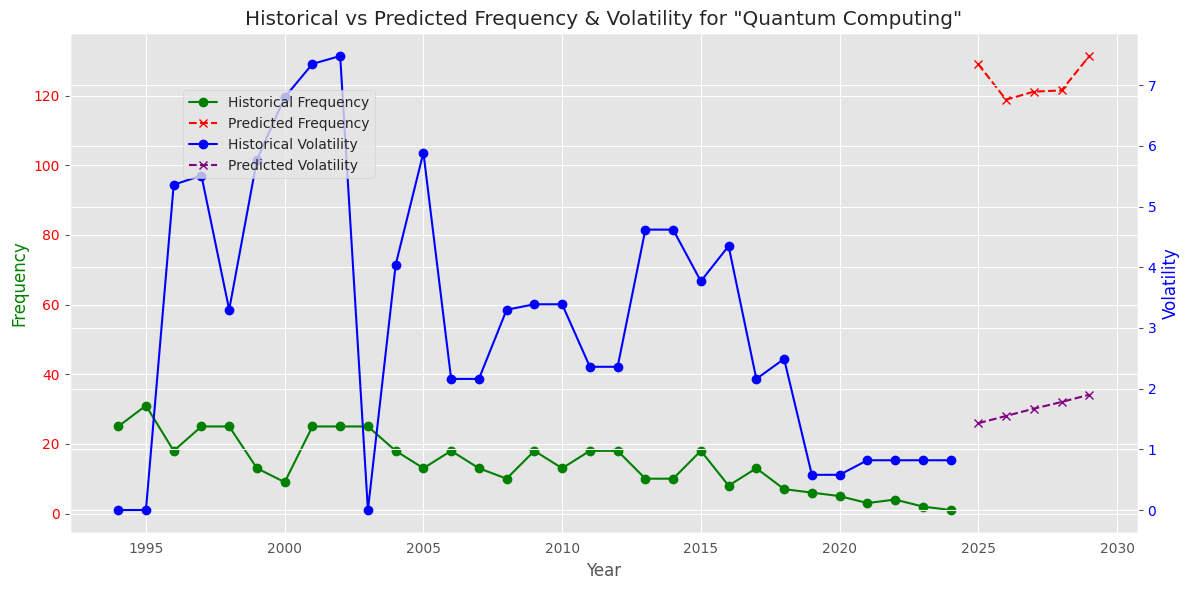

In [158]:
import matplotlib.pyplot as plt


historical_years = list(range(1994, 2025))
historical_frequency = [25, 31, 18, 25, 25, 13, 9, 25, 25, 25, 18, 13, 18, 13, 10, 18, 13, 18, 18, 10, 10, 18, 8, 13, 7, 6, 5, 3, 4, 2, 1]

historical_volatility = [
    0.0, 0.0, 5.36, 5.51, 3.3, 5.77, 6.8, 7.35, 7.48, 0.0,
    4.04, 5.89, 2.16, 2.16, 3.3, 3.39, 3.39, 2.36, 2.36, 4.62,
    4.62, 3.77, 4.35, 2.16, 2.49, 0.58, 0.58, 0.82, 0.82, 0.82,
    0.82
]


predicted_years = list(range(2025, 2030))
predicted_frequency = [129.06, 118.85, 121.18, 121.52, 131.40]
predicted_volatility = [1.43, 1.55, 1.67, 1.78, 1.90]

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(historical_years, historical_frequency, label='Historical Frequency', marker='o', color='green')
ax1.plot(predicted_years, predicted_frequency, label='Predicted Frequency', marker='x', color='red', linestyle='--')

ax1.set_xlabel('Year')
ax1.set_ylabel('Frequency', color='green')
ax1.set_title('Historical vs Predicted Frequency & Volatility for "Quantum Computing"')
ax1.tick_params(axis='y', labelcolor='red')


ax2 = ax1.twinx()
ax2.plot(historical_years, historical_volatility, label='Historical Volatility', marker='o', color='blue')
ax2.plot(predicted_years, predicted_volatility, label='Predicted Volatility', marker='x', color='purple', linestyle='--')


ax2.set_ylabel('Volatility', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9), bbox_transform=ax1.transAxes)


plt.grid(True)
plt.show()


In [159]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

historical_years = list(range(1994, 2025))
historical_frequency = [25, 31, 18, 25, 25, 13, 9, 25, 25, 25, 18, 13, 18, 13, 10, 18, 13, 18, 18, 10, 10, 18, 8, 13, 7, 6, 5, 3, 4, 2, 1]

historical_volatility = [
    0.0, 0.0, 5.36, 5.51, 3.3, 5.77, 6.8, 7.35, 7.48, 0.0,
    4.04, 5.89, 2.16, 2.16, 3.3, 3.39, 3.39, 2.36, 2.36, 4.62,
    4.62, 3.77, 4.35, 2.16, 2.49, 0.58, 0.58, 0.82, 0.82, 0.82,
    0.82
]



frequency_data = np.array(historical_frequency)
volatility_data = np.array(historical_volatility)


scaler = MinMaxScaler(feature_range=(0, 1))


frequency_data_scaled = scaler.fit_transform(frequency_data.reshape(-1, 1))
volatility_data_scaled = scaler.fit_transform(volatility_data.reshape(-1, 1))

train_frequency = frequency_data_scaled[:-5]
test_frequency = frequency_data_scaled[-5:]
train_volatility = volatility_data_scaled[:-5]
test_volatility = volatility_data_scaled[-5:]

def fit_arima_model(train_data):
    # Fit ARIMA model (p=1, d=1, q=1 for simplicity, adjust as needed)
    model = ARIMA(train_data, order=(1, 1, 1))
    model_fitted = model.fit()
    return model_fitted

# Train ARIMA model
frequency_arima_model = fit_arima_model(train_frequency)
volatility_arima_model = fit_arima_model(train_volatility)

forecast_frequency_arima = frequency_arima_model.forecast(steps=5)
forecast_volatility_arima = volatility_arima_model.forecast(steps=5)

# Step 3: LSTM Model for Frequency and Volatility Prediction
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

train_frequency_lstm = train_frequency.reshape((train_frequency.shape[0], 1, 1))
train_volatility_lstm = train_volatility.reshape((train_volatility.shape[0], 1, 1))

# Create and train LSTM models
frequency_lstm_model = create_lstm_model((train_frequency_lstm.shape[1], train_frequency_lstm.shape[2]))
volatility_lstm_model = create_lstm_model((train_volatility_lstm.shape[1], train_volatility_lstm.shape[2]))

# Training LSTM models
frequency_lstm_model.fit(train_frequency_lstm, train_frequency, epochs=50, batch_size=1, verbose=1)
volatility_lstm_model.fit(train_volatility_lstm, train_volatility, epochs=50, batch_size=1, verbose=1)

# Forecast with LSTM
test_frequency_lstm = test_frequency.reshape((test_frequency.shape[0], 1, 1))
test_volatility_lstm = test_volatility.reshape((test_volatility.shape[0], 1, 1))

forecast_frequency_lstm = frequency_lstm_model.predict(test_frequency_lstm)
forecast_volatility_lstm = volatility_lstm_model.predict(test_volatility_lstm)

# Step 4: Metrics Calculation
def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    r2 = r2_score(actual, predicted)
    return mae, rmse, r2

# Calculate metrics for ARIMA and LSTM
freq_mae_arima, freq_rmse_arima, freq_r2_arima = calculate_metrics(test_frequency, forecast_frequency_arima)
vol_mae_arima, vol_rmse_arima, vol_r2_arima = calculate_metrics(test_volatility, forecast_volatility_arima)

freq_mae_lstm, freq_rmse_lstm, freq_r2_lstm = calculate_metrics(test_frequency, forecast_frequency_lstm)
vol_mae_lstm, vol_rmse_lstm, vol_r2_lstm = calculate_metrics(test_volatility, forecast_volatility_lstm)

# Print Metrics for ARIMA and LSTM
print(f"ARIMA Frequency Metrics - MAE: {freq_mae_arima}, RMSE: {freq_rmse_arima}, R²: {freq_r2_arima}")
print(f"ARIMA Volatility Metrics - MAE: {vol_mae_arima}, RMSE: {vol_rmse_arima}, R²: {vol_r2_arima}")
print(f"LSTM Frequency Metrics - MAE: {freq_mae_lstm}, RMSE: {freq_rmse_lstm}, R²: {freq_r2_lstm}")
print(f"LSTM Volatility Metrics - MAE: {vol_mae_lstm}, RMSE: {vol_rmse_lstm}, R²: {vol_r2_lstm}")



Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.3295
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1537
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0194
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0215
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0122
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0127
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0124
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0132
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0090
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0049
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027
Epoch 13/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024
Epoch 14/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012
Epoch 15/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011
Epoch 16/50
26/26 ━